# Plot citation statistics for CMIP overview publications

In [1]:
# Updates
# PJD  5 Apr 2023 - Started
# PJD 13 Apr 2023 - Updated citation counts
# PJD 14 Apr 2023 - Augmented to include comparison models (CCSM4, CESM1, CESM2, E3SM-1-0)
# PJD 14 Apr 2023 - Augmented to consider all CMIP6 MIP papers
# PJD 12 Jul 2023 - Add CDRMIP durack1/MIPPlots#1; update all entries
# PJD 12 Jul 2023 - Add Charney 1979 and FANGIO/Cess 1990 durack1/MIPPlots#2
# PJD 26 Jul 2023 - Use per-MIP totals (from 12 Jul) to evaluate CMIP6 contributions
# PJD 14 Aug 2023 - Updated citation counts from WoS
# PJD 15 Aug 2023 - Updated bar plot
# PJD 18 Oct 2023 - Updated to write out CMIP3, CMIP5, CMIP6, CMIP6 Composite totals
# PJD 20 Dec 2023 - Updated citation counts from WoS and GSchol; Add CMIP6Plus
# PJD 20 Dec 2023 - Commenting 2024 values to prevent flat line
# PJD  2 May 2024 - Updating to use WoS Expanded API
# PJD  3 May 2024 - Switchout DOI with WoSID search as Meehl et al., 1995 not found
# PJD  4 May 2024 - Add apiKey function
# PJD  4 May 2024 - Added E3SM2 (Golaz et al., 2022)
# PJD  4 May 2024 - Compared old screenscrape with API calls for Fangio, AMIP, CMIP phases - ~equivalence validated
# PJD  4 May 2024 - All screenscrape values purged
# PJD  4 May 2024 - Added COVIDMIP (Lamboll et al., 2021 & Jones et al., 2021) https://github.com/durack1/MIPPlots/issues/7
# PJD  5 May 2024 - Added Google Scholar citation grab through SerpAPI
# PJD  6 May 2024 - Implemented Google Scholar SerpAPI citation grab
# PJD  6 May 2024 - Corrected Keller et al CDRMIP ref/doi
#                 TODO: UserWarning: FixedFormatter can be solved with guidance from
#                 https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator

# WoS APIs: WoS Expanded API required to get citations per year
# https://developer.clarivate.com/apis/wos, https://developer.clarivate.com/apis/wos-starter, https://developer.clarivate.com/apis
# ~/sync/Docs/admin/LLNL/24/230705_Clarivate-WebOfScience-API

## imports

In [2]:
%%time
import matplotlib.pyplot as plt
import numpy as np
import copy
import datetime
import logging
import requests

CPU times: user 262 ms, sys: 68.6 ms, total: 331 ms
Wall time: 404 ms


## function defs

In [3]:
WOS_API_URL = "https://wos-api.clarivate.com/api/wos"  # API Expanded
# https://api.clarivate.com/swagger-ui/?apikey=none&url=https%3A%2F%2Fdeveloper.clarivate.com%2Fapis%2Fwos%2Fswagger
WoSStarter_API_URL = "https://api.clarivate.com/apis/wos-starter/v1"  # Starter API
# https://api.clarivate.com/swagger-ui/?apikey=none&url=https%3A%2F%2Fdeveloper.clarivate.com%2Fapis%2Fwos-starter%2Fswagger

def apiKeyW():
    """
    Read WoS API key from local store
    """
    with open("WoSKey.txt", "r") as f:
        tmp = f.read()
        key = tmp.split()[-1]

    return key


def apiKeyG():
    """
    Read SerpAPI key from local store
    """
    with open("SerpKey.txt", "r") as f:
        tmp = f.read()
        key = tmp.split()[-1]

    return key


def grabCitationReport(queryId, params={}):
    """
    Use queryId to grab json output - every query counts as 1 against quota
    """
    headers = {"Accept": "application/json", "X-ApiKey": apiKeyW()}
    r = requests.get(
        WOS_API_URL + "/citation-report/" + str(queryId), params=params, headers=headers
    )
    try:
        rj = r.json()
        logging.debug("API response: {}".format(rj))
        return rj
    except:
        logging.exception("Citation report for queryId {} failed".format(queryId))
        raise


def grabGoogleScholarCites(doi):
    """
    User SerpAPI to scour citation counts from Google Scholar
    """
    params = {
        "api_key": apiKeyG(),
        "engine": "google_scholar",
        "q": doi,
        "hl": "en"
        }
    queryUrl = "https://serpapi.com/search.json?"
    r = requests.get(queryUrl, params=params)
    try:
        rj = r.json()
        logging.debug("SerpAPI response: {}".format(rj))
        googleScholCites = rj["organic_results"][0]["inline_links"]["cited_by"]["total"]
        if "authors" in rj["organic_results"][0]["publication_info"].keys():
            authorCount = len(rj["organic_results"][0]["publication_info"]["authors"])
            firstAuthorLastName = rj["organic_results"][0]["publication_info"]["authors"][0]["name"]
        else:
            authorCount = 0
            firstAuthorLastName = rj["organic_results"][0]["publication_info"]["summary"].split("-")[0].strip()
        if authorCount > 1:
            etal = "et al."
        else:
            etal = ""
        pubYr = rj["organic_results"][0]["publication_info"]["summary"].split("-")[1].split(",")[-1].strip()
        print("Processing GS:", firstAuthorLastName, etal, pubYr, googleScholCites)
    except:
        logging.exception(doi)
        raise

    return googleScholCites
    

def grabQueryId(query, params={}):
    """
    Send API dummy call - ping to get query ID, start connection
    """
    data = []
    # logger.debug('Query ID: {}'.format(queryId))

    query = {"databaseId": "WOS", "usrQuery": query, "count": 0, "firstRecord": 1}
    query.update(params)
    headers = {"Accept": "application/json", "X-ApiKey": apiKeyW()}
    # logging.info('Query parameters: {}'.format(query))
    # print(query)
    r = requests.get(WOS_API_URL, params=query, headers=headers)
    try:
        # print(r.text)
        rj = r.json()
        # print(rj)
        logging.debug("API response: {}".format(rj))
        queryId = rj["QueryResult"]["QueryID"]
        return queryId
    except:
        logging.exception(query)
        raise


def grabQueryReport(queryId, params={}):
    """
    Use queryId to grab json output - every query counts as 1 against quota
    """
    headers = {"Accept": "application/json", "X-ApiKey": apiKeyW()}
    r = requests.get(
        WOS_API_URL + "/query/" + str(queryId), params=params, headers=headers
    )
    try:
        rj = r.json()
        logging.debug("API response: {}".format(rj))
        return rj
    except:
        logging.exception("Citation report for queryId {} failed".format(queryId))
        raise


def pullStats(wosId, doi, padArray):
    """
    From WoS Expanded API DOI object extract time history of citations
    along with total citation count and pubYr
    """
    data = []
    # construct per call arguments and send to API
    params = "UT={}".format(wosId)
    #if doi != "":
    #    params = "&".join([params, "DO={}".format(doi)])
    queryId = grabQueryId(params)
    # query
    query = grabQueryReport(queryId)
    pubYr = query["Records"]["records"]["REC"][0]["static_data"]["summary"]["pub_info"]["pubyear"]
    authorCount = query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["count"]  # Author count
    if authorCount > 1:
        etal = "et al."
        firstAuthorLastName = query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["name"][0]["last_name"]
    else:
        etal = ""
        firstAuthorLastName = query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["name"]["last_name"]
    print("Processing WoS:", firstAuthorLastName, etal, pubYr)
    # citation-report
    crParams = {"reportLevel": "WOS"}
    crData = grabCitationReport(queryId, crParams)
    # pull entries out of data object
    citingYrsDict = crData[0]["CitingYears"]
    citingYrs = list(map(int, citingYrsDict.values()))
    timesCited = crData[0]["TimesCited"]    

    # ascertain length; generate padded citingYears - check pubYr against citeStartYr
    citeStartYr = int(list(citingYrsDict.keys())[0])
    startInd = citeStartYr-pubYr  # 0 if cited same year published
    #print("startInd:", startInd)
    #print("len(citingYrsPad):", len(citingYrsPad))
    indEnd = len(citingYrs)

    # padArray copy.deepcopy()
    citingYrsPad = copy.deepcopy(padArray)
    
    if startInd == -1:
        # count first two entries as one
        tmp = list(map(int, citingYrs))
        tmp1 = [np.sum(tmp[:2])]
        tmp1.extend(citingYrs[2:])
        citingYrs = tmp1
        del(tmp, tmp1)
        citingYrsPad[0:indEnd-1] = citingYrs
    elif startInd == 1:
        citingYrsPad[0] = 0
        citingYrsPad[startInd:indEnd+1] = list(map(int, citingYrs))
    elif startInd > 1:
        citingYrsPad[0:startInd] = list(map(int, np.zeros(startInd)))
        citingYrsPad[startInd:indEnd+startInd] = list(map(int, citingYrs))
    else:
        citingYrsPad[0:indEnd] = list(map(int, citingYrs))
    #print("len(citingYrsPad):", len(citingYrsPad))

    return pubYr, timesCited, citingYrs, citingYrsPad, citingYrsDict


## define time info

In [4]:
timeNow = datetime.datetime.now()
timeFormat = timeNow.strftime("%y%m%dT%H%M%S")
print("timeFormat:", timeFormat)

timeFormat: 240506T063932


## define input data from SerpAPI call - testing

In [5]:
"""
a, rj = grabGoogleScholarCites("10.1175/1520-0477-76.6.951") # 10.1126/science.1212222, 10.1175/BAMS-D-11-00094.1
print(rj.keys())
print()
print(rj["organic_results"][0]["publication_info"]["authors"][0]["name"])
print()
print(rj["organic_results"][0]["publication_info"]["summary"].split("-")[1].split(",")[-1].strip())
print()
print(len(rj["organic_results"][0]["publication_info"]["authors"]))
print()
print(rj["organic_results"][0]["inline_links"]["cited_by"]["total"])
"""

'\na, rj = grabGoogleScholarCites("10.1175/1520-0477-76.6.951") # 10.1126/science.1212222, 10.1175/BAMS-D-11-00094.1\nprint(rj.keys())\nprint()\nprint(rj["organic_results"][0]["publication_info"]["authors"][0]["name"])\nprint()\nprint(rj["organic_results"][0]["publication_info"]["summary"].split("-")[1].split(",")[-1].strip())\nprint()\nprint(len(rj["organic_results"][0]["publication_info"]["authors"]))\nprint()\nprint(rj["organic_results"][0]["inline_links"]["cited_by"]["total"])\n'

## define input data from WoS API call - testing

In [6]:
"""
APIKEY = apiKey()  # "WOS_EXPANDED_API_KEY"
doi = ""  #"10.1029/JD095iD10p16601"  #"10.1175/1520-0477-76.6.951"  #"10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2"  #"10.1029/JD095iD10p16601"
wosId = "A1992KD66500003" #"A1990EB20200022" #"000395187500001" #"000384624000001"  #"000364326200024"  #"A1992KD66500003" #"000226970100024" 
params = "UT={}".format(wosId)
queryId = grabQueryId(params, APIKEY)
query = grabQueryReport(queryId, APIKEY)
#print(query)
print(query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["name"]["last_name"])
#query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["name"][0]["last_name"]

# create filled pad list based on fangio 1990 published, 1991 citation to present
#currentYr = datetime.date.today().year
#tmp = np.arange(1990, currentYr+1)
#citingYrsPad = [np.nan]*len(tmp)

#pubYr, timesCited, citingYrs, citingYrsPad, citingYrsDict = pullStats(wosId, doi, citingYrsPad, APIKEY)
# list(zip(citingYearsDict.values(), fangio))  # compare two lists
"""

'\nAPIKEY = apiKey()  # "WOS_EXPANDED_API_KEY"\ndoi = ""  #"10.1029/JD095iD10p16601"  #"10.1175/1520-0477-76.6.951"  #"10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2"  #"10.1029/JD095iD10p16601"\nwosId = "A1992KD66500003" #"A1990EB20200022" #"000395187500001" #"000384624000001"  #"000364326200024"  #"A1992KD66500003" #"000226970100024" \nparams = "UT={}".format(wosId)\nqueryId = grabQueryId(params, APIKEY)\nquery = grabQueryReport(queryId, APIKEY)\n#print(query)\nprint(query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["name"]["last_name"])\n#query["Records"]["records"]["REC"][0]["static_data"]["summary"]["names"]["name"][0]["last_name"]\n\n# create filled pad list based on fangio 1990 published, 1991 citation to present\n#currentYr = datetime.date.today().year\n#tmp = np.arange(1990, currentYr+1)\n#citingYrsPad = [np.nan]*len(tmp)\n\n#pubYr, timesCited, citingYrs, citingYrsPad, citingYrsDict = pullStats(wosId, doi, citingYrsPad, APIKEY)\n# list(zip(citingYearsDi

In [7]:
"""
print("pubYr:", pubYr)
startYr = list(citingYrsDict.keys())[0]
endYr = list(citingYrsDict.keys())[-1]
print("citeYrs", list([startYr, endYr]))
print("timesCited:", timesCited)
print("citingYrs:\n", len(citingYrs), citingYrs)
print("citingYrsPad:\n", len(citingYrsPad), citingYrsPad)
amip1 = [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16,
         21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20]
cmip1 = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4]
fangio = [0, 11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 15]  # 1991-2023
#print(len(cmip1), cmip1)
citeYrsList = np.arange(int(pubYr), int(endYr)+1)
print("citeYrsList:\n", len(citeYrsList), citeYrsList)
"""

'\nprint("pubYr:", pubYr)\nstartYr = list(citingYrsDict.keys())[0]\nendYr = list(citingYrsDict.keys())[-1]\nprint("citeYrs", list([startYr, endYr]))\nprint("timesCited:", timesCited)\nprint("citingYrs:\n", len(citingYrs), citingYrs)\nprint("citingYrsPad:\n", len(citingYrsPad), citingYrsPad)\namip1 = [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16,\n         21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20]\ncmip1 = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4]\nfangio = [0, 11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 15]  # 1991-2023\n#print(len(cmip1), cmip1)\nciteYrsList = np.arange(int(pubYr), int(endYr)+1)\nprint("citeYrsList:\n", len(citeYrsList), citeYrsList)\n'

## define input data - Fangio, AMIP, CMIP phases

In [8]:
labels = ["AMIP1", "CMIP1", "CMIP2", "CMIP3", "CMIP5", "CMIP6", "CMIP6Composite"]

# create filled pad list based on fangio 1990 published, 1991 citation to present
currentYr = datetime.date.today().year
tmp = np.arange(1990, currentYr+1)
citingYrsPad = [np.nan]*len(tmp) 

# Charney National Research Council, 1979 National Academies Press
# https://doi.org/10.17226/12181
# https://scholar.google.com/scholar?cluster=15553179873625400927&hl=en&as_sdt=0,5
charneyG = grabGoogleScholarCites("10.17226/12181")

# FANGIO Cess et al., 1990 JGR
# https://doi.org/10.1029/JD095iD10p16601
# https://www.webofscience.com/wos/woscc/full-record/WOS:A1990EB20200022
# https://scholar.google.com/scholar?cluster=6135992129360534519&hl=en&as_sdt=0,5
_, _, fangioNoPad, fangio, _ = pullStats("A1990EB20200022", "10.1029/JD095iD10p16601", citingYrsPad)
fangioG = grabGoogleScholarCites("10.1029/JD095iD10p16601")
# Year since publication - based off longest
yrSincePublication = np.arange(0, len(fangio))

# AMIP1 Gates et al., 1992 BAMS
# https://doi.org/10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2
# 1992, 1993 https://www.webofscience.com/wos/woscc/full-record/WOS:A1992KD66500003
# https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=10.1175%2F1520-0477(1992)073%3C1962%3AATAMIP%3E2.0.CO%3B2
_, _, amip1NoPad, amip1, _ = pullStats("A1992KD66500003", "10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2", citingYrsPad)
amip1G = grabGoogleScholarCites("10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2")

# CMIP1 Meehl et al., 1995 BAMS
# https://doi.org/10.1175/1520-0477-76.6.951
# 1995, 1996 https://www.webofscience.com/wos/woscc/full-record/WOS:A1995RG21000008
# https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=10.1175/1520-0477-76.6.951
_, _, cmip1NoPad, cmip1, _ = pullStats("A1995RG21000008", "10.1175/1520-0477-76.6.951", citingYrsPad)
cmip1G = grabGoogleScholarCites("10.1175/1520-0477-76.6.951")

# CMIP2 Meehl et al., 2005 BAMS
# https://doi.org/10.1175/BAMS-86-1-89
# 2005 https://www.webofscience.com/wos/woscc/full-record/WOS:000226970100024
# https://scholar.google.com/scholar?cluster=414872318861866058&hl=en&as_sdt=0,5
_, _, cmip2NoPad, cmip2, _ = pullStats("000226970100024", "10.1175/BAMS-86-1-89", citingYrsPad)
cmip2G = grabGoogleScholarCites("10.1175/BAMS-86-1-89")

# CMIP3 Meehl et al., 2007 BAMS
# https://doi.org/10.1175/BAMS-88-9-1383
# 2007 https://www.webofscience.com/wos/woscc/full-record/WOS:000250166400004
# https://scholar.google.com/scholar?cluster=10102268002781422381&hl=en&as_sdt=0,5
_, _, cmip3NoPad, cmip3, _ = pullStats("000250166400004", "10.1175/BAMS-88-9-1383", citingYrsPad)
cmip3G = grabGoogleScholarCites("10.1175/BAMS-88-9-1383")

# CMIP5 Taylor et al., 2012 BAMS
# https://doi.org/10.1175/BAMS-D-11-00094.1
# 2012 https://www.webofscience.com/wos/woscc/full-record/WOS:000303110900004
# https://scholar.google.com/scholar?cluster=6589368678432360376&hl=en&as_sdt=0,5
_, _, cmip5NoPad, cmip5, _ = pullStats("000303110900004", "10.1175/BAMS-D-11-00094.1", citingYrsPad)
cmip5G = grabGoogleScholarCites("10.1175/BAMS-D-11-00094.1")

# CMIP6 Eyring et al., 2016 GMD
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000376937800013
# https://doi.org/10.5194/gmd-9-1937-2016
# https://scholar.google.com/scholar?cluster=5319430665468485905&hl=en&as_sdt=0,5
_, _, cmip6NoPad, cmip6, _ = pullStats("000376937800013", "10.5194/gmd-9-1937-2016", citingYrsPad)
cmip6G = grabGoogleScholarCites("10.5194/gmd-9-1937-2016")

print("Fangio, AMIP, CMIP phases data pull complete")

Processing GS: National Research Council  2008 848
Processing WoS: CESS et al. 1990
Processing GS: GL Potter  1990 1117
Processing WoS: GATES  1992
Processing GS: WL Gates  1992 1616
Processing WoS: MEEHL  1995
Processing GS: GA Meehl  1995 68
Processing WoS: Meehl et al. 2005
Processing GS: GA Meehl et al. 2005 378
Processing WoS: Meehl et al. 2007
Processing GS: GA Meehl et al. 2007 3398
Processing WoS: Taylor et al. 2012
Processing GS: KE Taylor et al. 2012 14794
Processing WoS: Eyring et al. 2016
Processing GS: V Eyring et al. 2016 7012
Fangio, AMIP, CMIP phases data pull complete


## define input data - CMIP6 Community MIPs

In [9]:
# CMIP6 MIPs - https://gmd.copernicus.org/articles/special_issue590.html + CDRMIP
# 2016 -
# aerchemmip - Collins et al., 2017
# https://doi.org/10.5194/gmd-10-585-2017
# 2017 https://www.webofscience.com/wos/woscc/full-record/WOS:000395391000001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-10-585-2017
_, _, aerchemmipNoPad, aerchemmip, _ = pullStats("000395391000001", "10.5194/gmd-10-585-2017", citingYrsPad)
aerchemmipG = grabGoogleScholarCites("10.5194/gmd-10-585-2017")
# c4mip - Jones et al., 2016
# https://doi.org/10.5194/gmd-9-2853-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000383844500002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2853-2016
_, _, c4mipNoPad, c4mip, _ = pullStats("000383844500002", "10.5194/gmd-9-2853-2016", citingYrsPad)
c4mipG = grabGoogleScholarCites("10.5194/gmd-9-2853-2016")
# cdrmip - Keller et al., 2018
# https://doi.org/10.5194/gmd-11-1133-2018
# 2018 https://www.webofscience.com/wos/woscc/full-record/WOS:000428836100001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-11-1133-2018
_, _, cdrmipNoPad, cdrmip, _ = pullStats("000428836100001", "10.5194/gmd-11-1133-2018", citingYrsPad)
cdrmipG = grabGoogleScholarCites("10.5194/gmd-11-1133-2018")
# cfmip - Webb et al., 2017
# https://doi.org/10.5194/gmd-10-359-2017
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000395187500001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-10-359-2017
_, _, cfmipNoPad, cfmip, _ = pullStats("000395187500001", "10.5194/gmd-10-359-2017", citingYrsPad)
cfmipG = grabGoogleScholarCites("10.5194/gmd-10-359-2017")
# cordex - Gutowski et al., 2016
# https://doi.org/10.5194/gmd-9-4087-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000387989000001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-4087-2016
_, _, cordexNoPad, cordex, _ = pullStats("000387989000001", "10.5194/gmd-9-4087-2016", citingYrsPad)
cordexG = grabGoogleScholarCites("10.5194/gmd-9-4087-2016")
# damip - Gillett et al., 2016
# https://doi.org/10.5194/gmd-9-3685-2016
# 2017 https://www.webofscience.com/wos/woscc/full-record/WOS:000386585100001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3685-2016
_, _, damipNoPad, damip, _ = pullStats("000386585100001", "10.5194/gmd-9-3685-2016", citingYrsPad)
damipG = grabGoogleScholarCites("10.5194/gmd-9-3685-2016")
# dcpp - Boer et al., 2016
# https://doi.org/10.5194/gmd-9-3751-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000387064200001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3751-2016
_, _, dcppNoPad, dcpp, _ = pullStats("000387064200001", "10.5194/gmd-9-3751-2016", citingYrsPad)
dcppG = grabGoogleScholarCites("10.5194/gmd-9-3751-2016")
# dynvarmip - Gerber & Manzini, 2016
# https://doi.org/10.5194/gmd-9-3413-2016
# 2018 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3413-2016
_, _, dynvarmipNoPad, dynvarmip, _ = pullStats("000384624000001", "10.5194/gmd-9-3413-2016", citingYrsPad)
dynvarmipG = grabGoogleScholarCites("10.5194/gmd-9-3413-2016")
# fafmip - Gregory et al., 2016
# https://doi.org/10.5194/gmd-9-3993-2016
# 2017 https://www.webofscience.com/wos/woscc/full-record/WOS:000387988500001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3993-2016
_, _, fafmipNoPad, fafmip, _ = pullStats("000387988500001", "10.5194/gmd-9-3993-2016", citingYrsPad)
fafmipG = grabGoogleScholarCites("10.5194/gmd-9-3993-2016")
# geomip6 - Kravitz et al., 2015
# https://doi.org/10.5194/gmd-8-3379-2015
# 2015 https://www.webofscience.com/wos/woscc/full-record/WOS:000364326200024
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-8-3379-2015
_, _, geomip6NoPad, geomip6, _ = pullStats("000364326200024", "10.5194/gmd-8-3379-2015", citingYrsPad)
geomip6G = grabGoogleScholarCites("10.5194/gmd-8-3379-2015")
# gmmip - Zhou et al., 2016
# https://doi.org/10.5194/gmd-9-3589-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000385387800001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3589-2016
_, _, gmmip6NoPad, gmmip, _ = pullStats("000385387800001", "10.5194/gmd-9-3589-2016", citingYrsPad)
gmmipG = grabGoogleScholarCites("10.5194/gmd-9-3589-2016")
# highresmip - Haarsma et al., 2016
# https://doi.org/10.5194/gmd-9-4185-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000388191000002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-4185-2016
_, _, highresmipNoPad, highresmip, _ = pullStats("000388191000002", "10.5194/gmd-9-4185-2016", citingYrsPad)
highresmipG = grabGoogleScholarCites("10.5194/gmd-9-4185-2016")
# ismip6 - Nowicki et al., 2016
# https://doi.org/10.5194/gmd-9-4521-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000391579600002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-4521-2016
_, _, ismip6NoPad, ismip6, _ = pullStats("000391579600002", "10.5194/gmd-9-4521-2016", citingYrsPad)
ismip6G = grabGoogleScholarCites("10.5194/gmd-9-4521-2016")
# ls3mip - van den Hurk et al., 2016
# https://doi.org/10.5194/gmd-9-2809-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000383800400002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2809-2016
_, _, ls3mipNoPad, ls3mip, _ = pullStats("000383800400002", "10.5194/gmd-9-2809-2016", citingYrsPad)
ls3mipG = grabGoogleScholarCites("10.5194/gmd-9-2809-2016")
# lumip - Lawrence et al., 2016
# https://doi.org/10.5194/gmd-9-2973-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000383892800002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2973-2016
_, _, lumipNoPad, lumip, _ = pullStats("000383892800002", "10.5194/gmd-9-2973-2016", citingYrsPad)
lumipG = grabGoogleScholarCites("10.5194/gmd-9-2973-2016")
# omip1 - Griffies et al., 2016
# https://doi.org/10.5194/gmd-9-3231-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000384321500001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3231-2016
_, _, omip1NoPad, omip1, _ = pullStats("000384321500001", "10.5194/gmd-9-3231-2016", citingYrsPad)
omip1G = grabGoogleScholarCites("10.5194/gmd-9-3231-2016")
# omip2 - Orr et al., 2017
# https://doi.org/10.5194/gmd-10-2169-2017
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000403231800001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-10-2169-2017
_, _, omip2NoPad, omip2, _ = pullStats("000403231800001", "10.5194/gmd-10-2169-2017", citingYrsPad)
omip2G = grabGoogleScholarCites("10.5194/gmd-10-2169-2017")
# pamip - Smith et al., 2019
# https://doi.org/10.5194/gmd-12-1139-2019
# 2019 https://www.webofscience.com/wos/woscc/full-record/WOS:000462352700002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-12-1139-2019
_, _, pamipNoPad, pamip, _ = pullStats("000462352700002", "10.5194/gmd-12-1139-2019", citingYrsPad)
pamipG = grabGoogleScholarCites("10.5194/gmd-12-1139-2019")
# pmip4 - Kageyama et al., 2018
# https://doi.org/10.5194/gmd-11-1033-2018
# 2018 https://www.webofscience.com/wos/woscc/full-record/WOS:000427841800004
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-11-1033-2018
_, _, pmip4NoPad, pmip4, _ = pullStats("000427841800004", "10.5194/gmd-11-1033-2018", citingYrsPad)
pmip4G = grabGoogleScholarCites("10.5194/gmd-11-1033-2018")
# rfmip - Pincus et al., 2016
# https://doi.org/10.5194/gmd-9-3447-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385300001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3447-2016
_, _, rfmipNoPad, rfmip, _ = pullStats("000385385300001", "10.5194/gmd-9-3447-2016", citingYrsPad)
rfmipG = grabGoogleScholarCites("10.5194/gmd-9-3447-2016")
# scenariomip - O'Neill et al., 2016
# https://doi.org/10.5194/gmd-9-3461-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385700001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3461-2016
_, _, scenariomipNoPad, scenariomip, _ = pullStats("000385385700001", "10.5194/gmd-9-3461-2016", citingYrsPad)
scenariomipG = grabGoogleScholarCites("10.5194/gmd-9-3461-2016")
# simip - Notz et al., 2016
# https://doi.org/10.5194/gmd-9-3427-2016
# 2017 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000002, 65 web of scienc
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3427-2016
_, _, simipNoPad, simip, _ = pullStats("000384624000002", "10.5194/gmd-9-3427-2016", citingYrsPad)
simipG = grabGoogleScholarCites("10.5194/gmd-9-3427-2016")
# viacsab - Ruane et al., 2016
# https://doi.org/10.5194/gmd-9-3493-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000385386000002
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3493-2016
_, _, viacsabNoPad, viacsab, _ = pullStats("000385386000002", "10.5194/gmd-9-3493-2016", citingYrsPad)
viacsabG = grabGoogleScholarCites("10.5194/gmd-9-3493-2016")
# volmip - Zanchettin et al., 2016
# https://doi.org/10.5194/gmd-9-2701-2016
# 2016 https://www.webofscience.com/wos/woscc/full-record/WOS:000383794200001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2701-2016
_, _, volmipNoPad, volmip, _ = pullStats("000383794200001", "10.5194/gmd-9-2701-2016", citingYrsPad)
volmipG = grabGoogleScholarCites("10.5194/gmd-9-2701-2016")
# zecmip - Jones et al., 2019
# https://doi.org/10.5194/gmd-12-4375-2019
# 2019 https://www.webofscience.com/wos/woscc/full-record/WOS:000490550000001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-12-4375-2019
_, _, zecmipNoPad, zecmip, _ = pullStats("000490550000001", "10.5194/gmd-12-4375-2019", citingYrsPad)
zecmipG = grabGoogleScholarCites("10.5194/gmd-12-4375-2019")
# covidmip - Lamboll et al., 2021
# https://doi.org/10.5194/gmd-14-3683-2021
# 2021 https://www.webofscience.com/wos/woscc/full-record/WOS:000665538700002
_, _, covidmipNoPad, covidmip, _ = pullStats("000665538700002", "10.5194/gmd-14-3683-2021", citingYrsPad)
covidmipG = grabGoogleScholarCites("10.5194/gmd-14-3683-2021")
# covidmip2 - Jones et al., 2021
# https://doi.org/10.1029/2020GL091883
# 2021 https://www.webofscience.com/wos/woscc/full-record/WOS:000672324900006
_, _, covidmip2NoPad, covidmip2, _ = pullStats("000672324900006", "10.1029/2020GL091883", citingYrsPad)
covidmip2G = grabGoogleScholarCites("10.1029/2020GL091883")

print("CMIP6 Community MIPs data pull complete")

Processing WoS: Collins et al. 2017
Processing GS: WJ Collins et al. 2017 172
Processing WoS: Jones et al. 2016
Processing GS: CD Jones et al. 2016 173
Processing WoS: Keller et al. 2018
Processing GS: DP Keller et al. 2018 108
Processing WoS: Webb et al. 2017
Processing GS: MJ Webb et al. Salcedo… 193
Processing WoS: Gutowski et al. 2016
Processing GS: WJ Gutowski Jr et al. 2016 325
Processing WoS: Gillett et al. 2016
Processing GS: NP Gillett et al. 2016 303
Processing WoS: Boer et al. 2016
Processing GS: GJ Boer, DM Smith, C Cassou…  2016 292
Processing WoS: Gerber et al. 2016
Processing GS: EP Gerber et al. 2016 29
Processing WoS: Gregory et al. 2016
Processing GS: JM Gregory et al. 2016 145
Processing WoS: Kravitz et al. 2015
Processing GS: B Kravitz et al. 2015 157
Processing WoS: Zhou et al. 2016
Processing GS: T Zhou et al. 2016 86
Processing WoS: Haarsma et al. 2016
Processing GS: RJ Haarsma et al. 2016 683
Processing WoS: Nowicki et al. 2016
Processing GS: SMJ Nowicki et al. 

## define input data - CMIP6Plus Community MIPs

In [10]:
# CMIP6Plus MIPs - https://wcrp-cmip.org/mips/#registered-mips
# ceresmip - Schmidt et al., 2022
# https://doi.org/10.3389/fclim.2023.1202161
# 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:001023169300001
# https://scholar.google.com/scholar?hl=en&q=10.3389/fclim.2023.1202161
_, _, ceresmipNoPad, ceresmip, _ = pullStats("001023169300001", "10.3389/fclim.2023.1202161", citingYrsPad)
ceresmipG = grabGoogleScholarCites("10.3389/fclim.2023.1202161")

# lesfmip - Smith et al., 2022
# https://doi.org/10.3389/fclim.2022.955414
# 2022 https://www.webofscience.com/wos/woscc/full-record/WOS:001019276100001
# https://scholar.google.com/scholar?hl=en&q=10.3389/fclim.2022.955414
_, _, lesfmipNoPad, lesfmip, _ = pullStats("001019276100001", "10.3389/fclim.2022.955414", citingYrsPad)
lesfmipG = grabGoogleScholarCites("10.3389/fclim.2022.955414")

# ramip - Wilcox et al., 2023
# https://doi.org/10.5194/gmd-16-4451-2023
# 2024 https://www.webofscience.com/wos/woscc/full-record/WOS:001042156200001
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-16-4451-2023
_, _, ramipNoPad, ramip, _ = pullStats("001042156200001", "10.5194/gmd-16-4451-2023", citingYrsPad)
ramipG = grabGoogleScholarCites("10.5194/gmd-16-4451-2023")

print("CMIP6Plus Community MIPs data pull complete")

Processing WoS: Schmidt et al. 2023
Processing GS: GA Schmidt et al. 2023 6
Processing WoS: Smith et al. 2022
Processing GS: DM Smith et al. 2022 16
Processing WoS: Wilcox et al. 2023
Processing GS: LJ Wilcox et al. 2022 9
CMIP6Plus Community MIPs data pull complete


## define input data - Models

In [11]:
# Models
# E3SM-1-0 Golaz et al., 2019 JAMES
# https://doi.org/10.1029/2018MS001603
# 2019 https://www.webofscience.com/wos/woscc/full-record/WOS:000480282800012
# https://scholar.google.com/scholar?hl=en&q=10.1029/2018MS001603
# https://doi.org/10.1029/2019MS001870 - Caldwell et al., 2019 high resolution ~74 citations
_, _, e3sm1_0NoPad, e3sm1_0, _ = pullStats("000480282800012", "10.1029/2018MS001603", citingYrsPad)
e3sm1_0G = grabGoogleScholarCites("10.1029/2018MS001603")

# E3SM-2-0 Golaz et al., 2022 JAMES
# https://doi.org/10.1029/2022MS003156
# 2022 https://www.webofscience.com/wos/woscc/full-record/WOS:000924492900001
# https://scholar.google.com/scholar?hl=en&q=10.1029/2022MS003156
_, _, e3sm2_0NoPad, e3sm2_0, _ = pullStats("000924492900001", "10.1029/2022MS003156", citingYrsPad)
e3sm2_0G = grabGoogleScholarCites("10.1029/2022MS003156")

# CCSM4 Gent et al., 2011 JCL
# https://doi.org/10.1175/2011JCLI4083.1
# 2011 https://www.webofscience.com/wos/woscc/full-record/WOS:000295905400001
# https://scholar.google.com/scholar?hl=en&q=10.1175/2011JCLI4083.1
_, _, ccsm4NoPad, ccsm4, _ = pullStats("000295905400001", "10.1175/2011JCLI4083.1", citingYrsPad)
ccsm4G = grabGoogleScholarCites("10.1175/2011JCLI4083.1")

# CESM1 Hurrell et al., 2013 BAMS
# https://doi.org/10.1175/BAMS-D-12-00121.1
# 2013 https://www.webofscience.com/wos/woscc/full-record/WOS:000325135100007
# https://scholar.google.com/scholar?hl=en&q=10.1175/BAMS-D-12-00121.1
_, _, cesm1NoPad, cesm1, _ = pullStats("000325135100007", "10.1175/BAMS-D-12-00121.1", citingYrsPad)
cesm1G = grabGoogleScholarCites("10.1175/BAMS-D-12-00121.1")

# CESM2 Danabasoglu et al., 2020 JAMES
# https://doi.org/10.1029/2019MS001916
# 2020 https://www.webofscience.com/wos/woscc/full-record/WOS:000519728500010
# https://scholar.google.com/scholar?hl=en&q=10.1029/2019MS001916
_, _, cesm2NoPad, cesm2, _ = pullStats("000519728500010", "10.1029/2019MS001916", citingYrsPad)
cesm2G = grabGoogleScholarCites("10.1029/2019MS001916")

print("Models data pull complete")

Processing WoS: Golaz et al. 2019
Processing GS: JC Golaz et al. 2019 516
Processing WoS: Golaz et al. 2022
Processing GS: JC Golaz et al. 2022 81
Processing WoS: Gent et al. 2011
Processing GS: PR Gent et al. 2011 3030
Processing WoS: Hurrell et al. 2013
Processing GS: JW Hurrell et al. 2013 2354
Processing WoS: Danabasoglu et al. 2020
Processing GS: JF Lamarque  2020 1500
Models data pull complete


## display all data

In [12]:
# Prints
print("Grey literature uptick? (Google Scholar/Web of Science)")

print("Fangio; Cess et al., 1990:".ljust(28), "{:.2f}".format(fangioG/np.nansum(fangio)))
print("AMIP1;  Gates, 1992:".ljust(28), "{:.2f}".format(amip1G/np.nansum(amip1)))
print("CMIP1;  Meehl, 1995:".ljust(28), "{:.2f}".format(cmip1G/np.nansum(cmip1)))
print("CMIP2;  Meehl et al., 2005:".ljust(28), "{:.2f}".format(cmip2G/np.nansum(cmip2)))
print("CMIP3;  Meehl et al., 2007:".ljust(28), "{:.2f}".format(cmip3G/np.nansum(cmip3)))
print("CMIP5;  Taylor et al., 2012:".ljust(28), "{:.2f}".format(cmip5G/np.nansum(cmip5)))
print("CMIP6;  Eyring et al., 2016:".ljust(28), "{:.2f}".format(cmip6G/np.nansum(cmip6)))
print()
print("yrSincePublication:", list(map(int, yrSincePublication)))
# fangioO fudge
fangioO = [11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 15]  # 1991-2023
fangioO.insert(0, 0)
fangioO.insert(len(fangioO), np.nan)
diff = np.array(fangio)-np.array(fangioO)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("fangio:\n", "new", np.nansum(fangio), fangio, "\n", "old", int(np.nansum(fangioO)), fangioO, "\n", "diff.  ", diff)
# amip1 fudge
amip1O = [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16, 21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20]  # 1993-2023
amip1O.extend([np.nan]*3)
diff = np.array(amip1)-np.array(amip1O)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("amip1:\n", "new", int(np.nansum(amip1)), amip1, "\n", "old", int(np.nansum(amip1O)), amip1O, "\n", "diff.  ", diff)
# cmip1 fudge
cmip1O = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4] # 2023
cmip1O.extend([np.nan]*15)
diff = np.array(cmip1)-np.array(cmip1O)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("cmip1:\n", "new", int(np.nansum(cmip1)), cmip1, "\n", "old", int(np.nansum(cmip1O)), cmip1O, "\n", "diff. ", diff)
# cmip2 fudge
cmip2O = [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 10, 13] # 2023, 2]  # 2024
cmip2O.extend([np.nan]*16)
diff = np.array(cmip2)-np.array(cmip2O)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("cmip2:\n", "new", int(np.nansum(cmip2)), cmip2, "\n", "old", int(np.nansum(cmip2O)), cmip2O, "\n", "diff.  ", diff)
# cmip3 fudge
cmip3O = [3, 28, 100, 131, 188, 265, 315, 206, 187, 145, 121, 104, 87, 108, 69, 68, 55]  # 2023
cmip3O.extend([np.nan]*18)
diff = np.array(cmip3)-np.array(cmip3O)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("cmip3:\n", "new", int(np.nansum(cmip3)), cmip3, "\n", "old", int(np.nansum(cmip3O)), cmip3O, "\n", "diff.   ", diff)
# cmip5 fudge
cmip5O = [98, 503, 619, 838, 919, 1010, 1249, 1291, 1250, 1183, 896, 580] # 2023, 2]  # 2024
cmip5O.extend([np.nan]*23)
diff = np.array(cmip5)-np.array(cmip5O)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("cmip5:\n", "new", int(np.nansum(cmip5)), cmip5, "\n", "old", int(np.nansum(cmip5O)), cmip5O, "\n", "diff.    ", diff)
# cmip6 fudge
cmip6O = [23, 58, 112, 155, 544, 940, 1317, 1261] # 2023, 6]  # 2024
cmip6O.extend([np.nan]*27)
diff = np.array(cmip6)-np.array(cmip6O)
diff[np.isnan(diff)] = 0.
diff = list(map(int, diff))
print("cmip6:\n", "new", int(np.nansum(cmip6)), cmip6, "\n", "old", int(np.nansum(cmip6O)), cmip6O, "\n", "diff.   ", diff)

# Generate composite CMIP6
cmip6Comp = np.nansum([aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
                       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
                       simip, viacsab, volmip, zecmip, covidmip, covidmip2], 0)
cmip6Comp[cmip6Comp == 0.] = np.nan  # wash zeros to nan
cmip6Compa = copy.deepcopy(citingYrsPad)
cmip6Compa[:len(cmip6Comp)] = cmip6Comp
cmip6Comp = cmip6Compa
del(cmip6Compa)
cmip6CompA = np.nansum([cmip6, cmip6Comp], 0)
cmip6CompA = np.where(cmip6CompA == 0., np.nan, cmip6CompA)
print("cmip6CompA:", np.nansum(cmip6CompA), cmip6CompA)

# Generate CMIP3-> composite
print("CMOR composite:",np.sum([np.nansum(cmip3), np.nansum(cmip5), np.nansum(cmip6CompA)]))

print(simip)

Grey literature uptick? (Google Scholar/Web of Science)
Fangio; Cess et al., 1990:   1.51
AMIP1;  Gates, 1992:         1.68
CMIP1;  Meehl, 1995:         1.58
CMIP2;  Meehl et al., 2005:  1.48
CMIP3;  Meehl et al., 2007:  1.52
CMIP5;  Taylor et al., 2012: 1.37
CMIP6;  Eyring et al., 2016: 1.37

yrSincePublication: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
fangio:
 new 739 [0, 11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 21, 24, 18, 27, 19, 26, 12, 19, 5] 
 old 727 [0, 11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 15, nan] 
 diff.   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 4, 0]
amip1:
 new 962 [0, 1, 18, 50, 54, 60, 67, 60, 62, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 18, 21, 25, 30, 33, 24, 27, 27, 25, 

## first plot - MIPs only

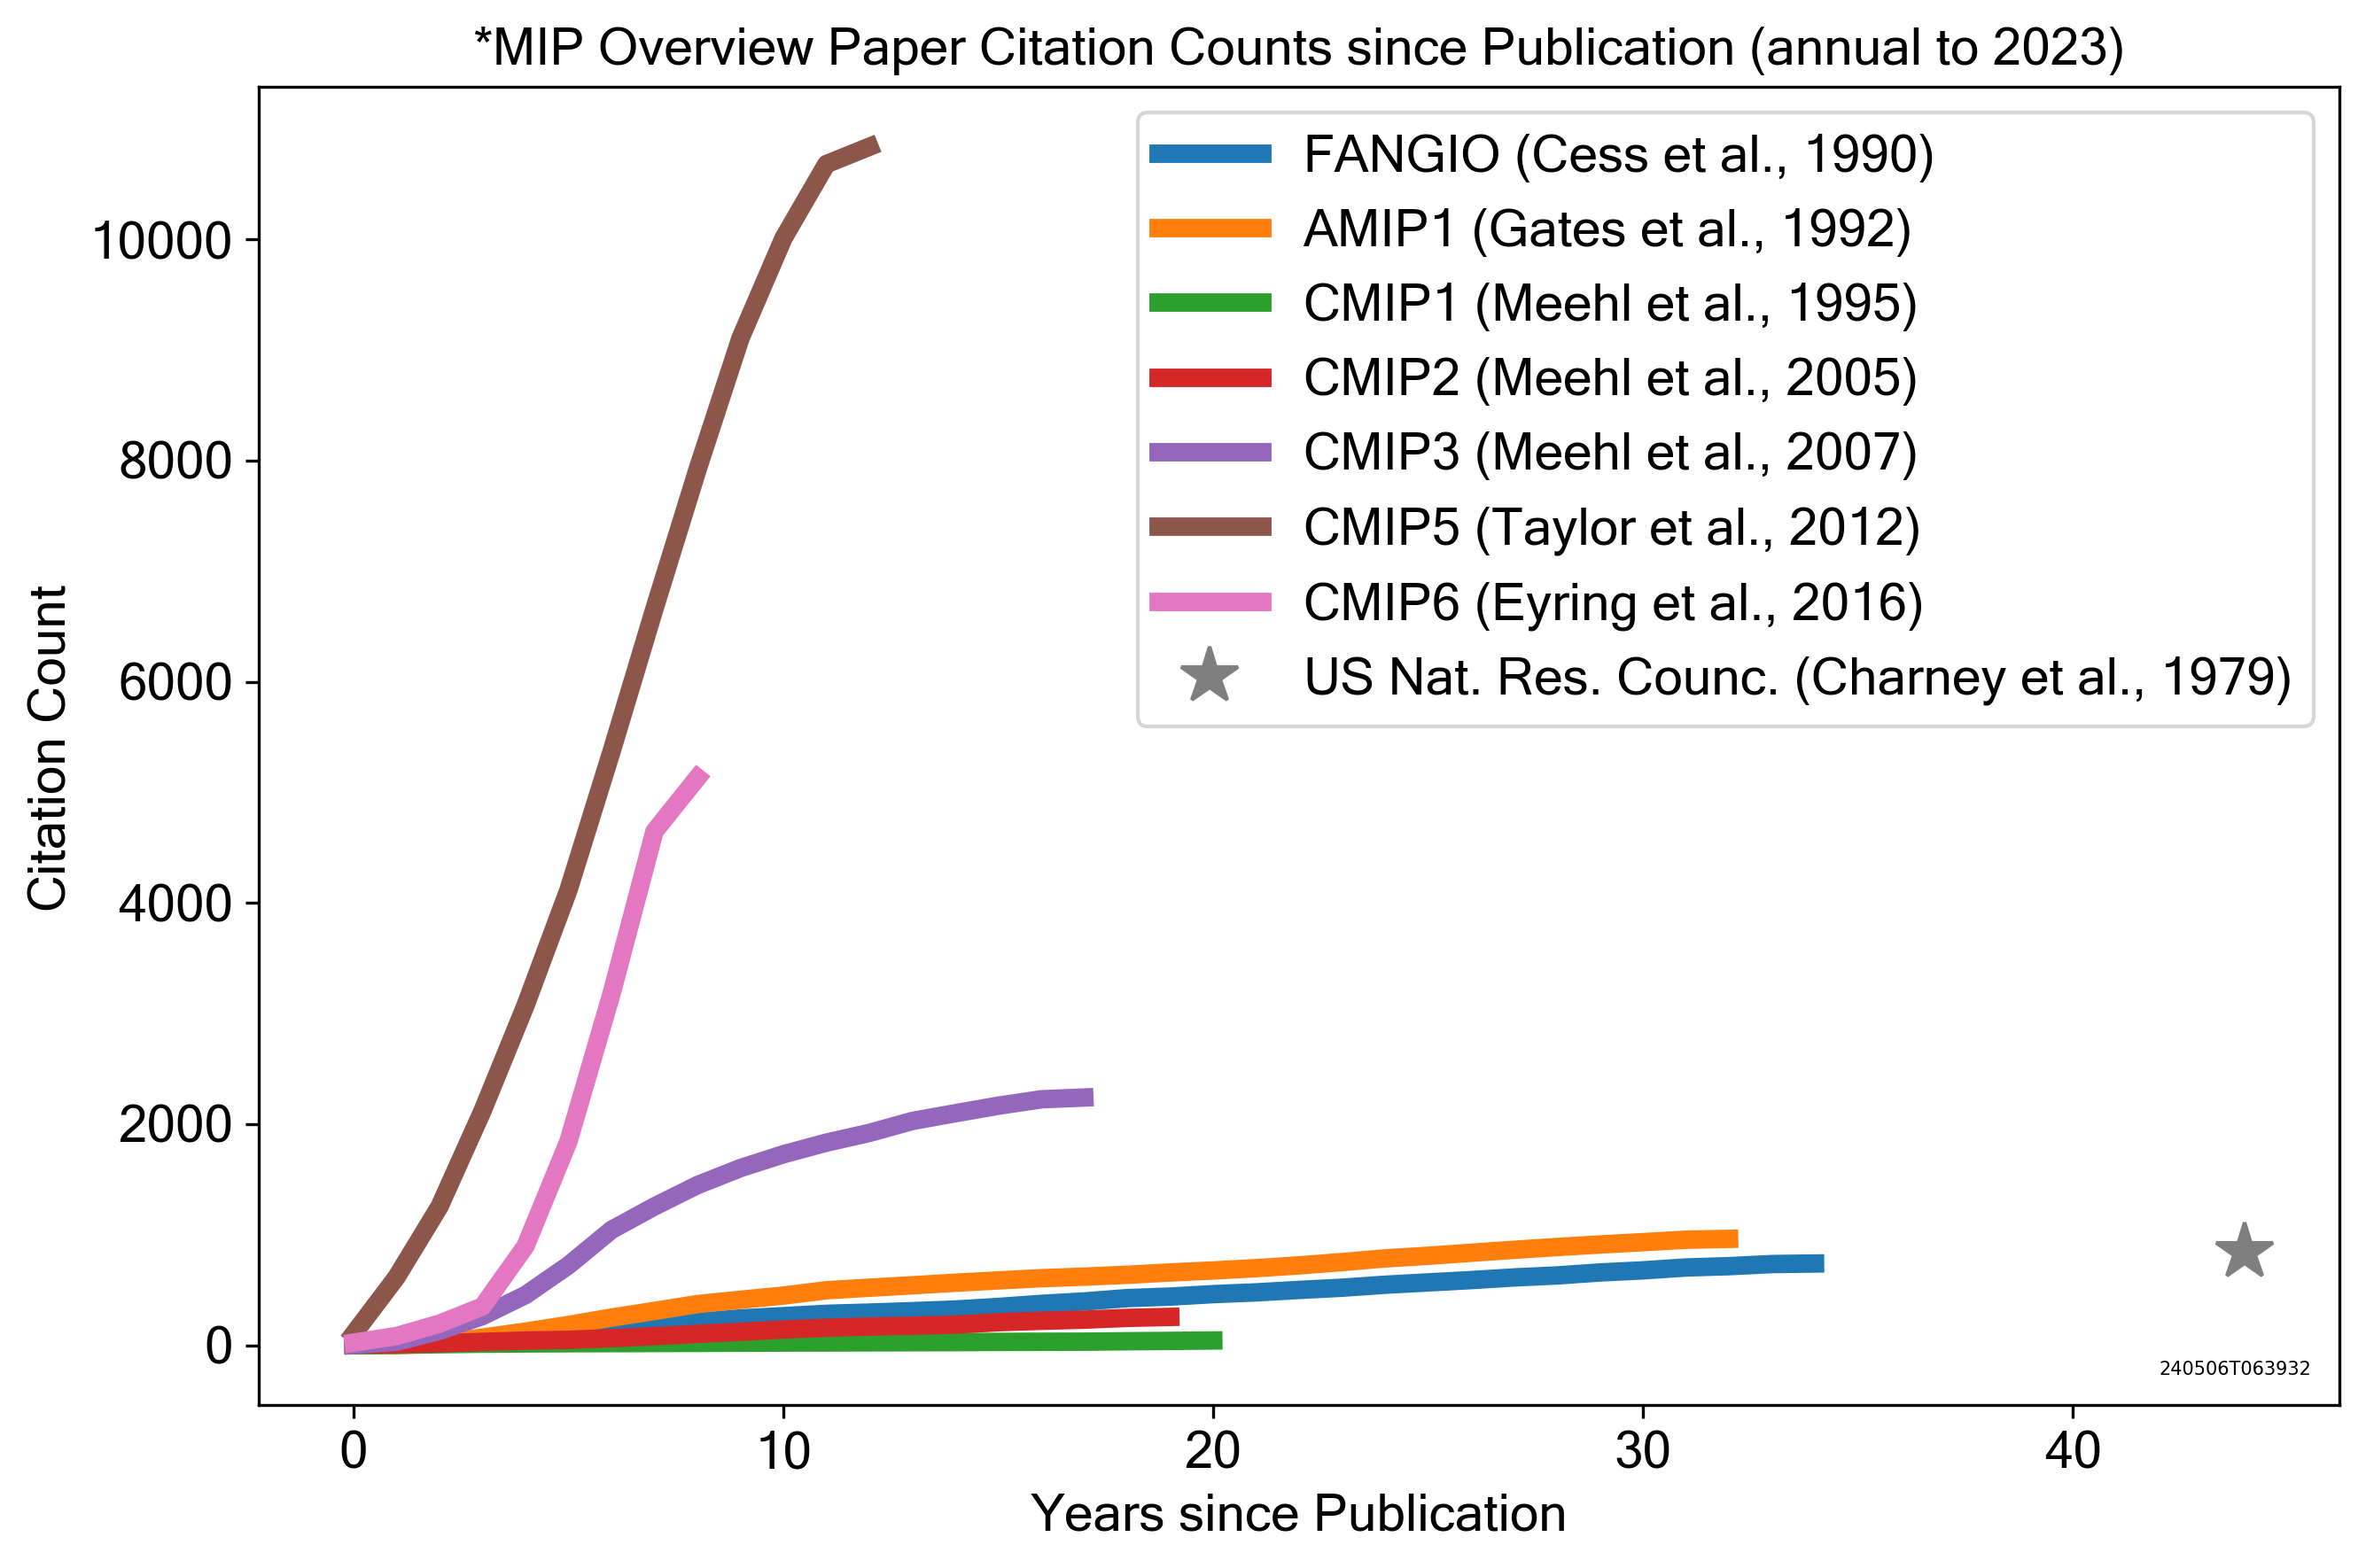

In [13]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
star0 = plt.plot(2023-1979, charneyG, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title, custom x-axis tick labels, etc.
ax.set_title("".join(["*MIP Overview Paper Citation Counts since Publication (annual to ", str(currentYr-1), ")"]),
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})
plt.text(42, -270, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save, close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-1.png"]))

## second plot (a) - Contributing MIPs - line plot

actLabels: 26 ['AerChemMIP (Collins et al., 2017); 164', 'C4MIP (Jones et al., 2016); 165', 'CDRMIP (Keller et al., 2018); 99', 'CFMIP (Webb et al., 2017); 184', 'CORDEX (Gutowski et al., 2016); 254', 'DAMIP (Gillett et al., 2016); 268', 'DCPP (Boer et al., 2016); 269', 'DynVarMIP (Gerber & Manzini, 2016); 28', 'FAFMIP (Gregory et al., 2016); 117', 'GeoMIP6 (Kravitz et al., 2015); 134', 'GMMIP (Zhou et al., 2016); 76', 'HighResMIP (Haarsma et al., 2016); 616', 'ISMIP6 (Nowicki et al., 2016); 151', 'LS3MIP (van den Hurk et al., 2016); 138', 'LUMIP (Lawrence et al., 2016); 293', 'OMIP-Phys. (Griffies et al., 2016); 215', 'OMIP-BioGeoChem. (Orr et al., 2017); 136', 'PAMIP (Smith et al., 2019); 169', 'PMIP4 (Kageyama et al., 2018); 144', 'RFMIP (Pincus et al., 2016); 158', "ScenarioMIP (O'Neill et al., 2016); 1995", 'SIMIP (Notz et al., 2016); 72', 'VIACS AB (Ruane et al., 2016); 30', 'VolMIP (Zanchettin et al., 2016); 130', 'ZECMIP (Jones et al., 2019); 43', 'COVIDMIP (Lamboll et al., 202

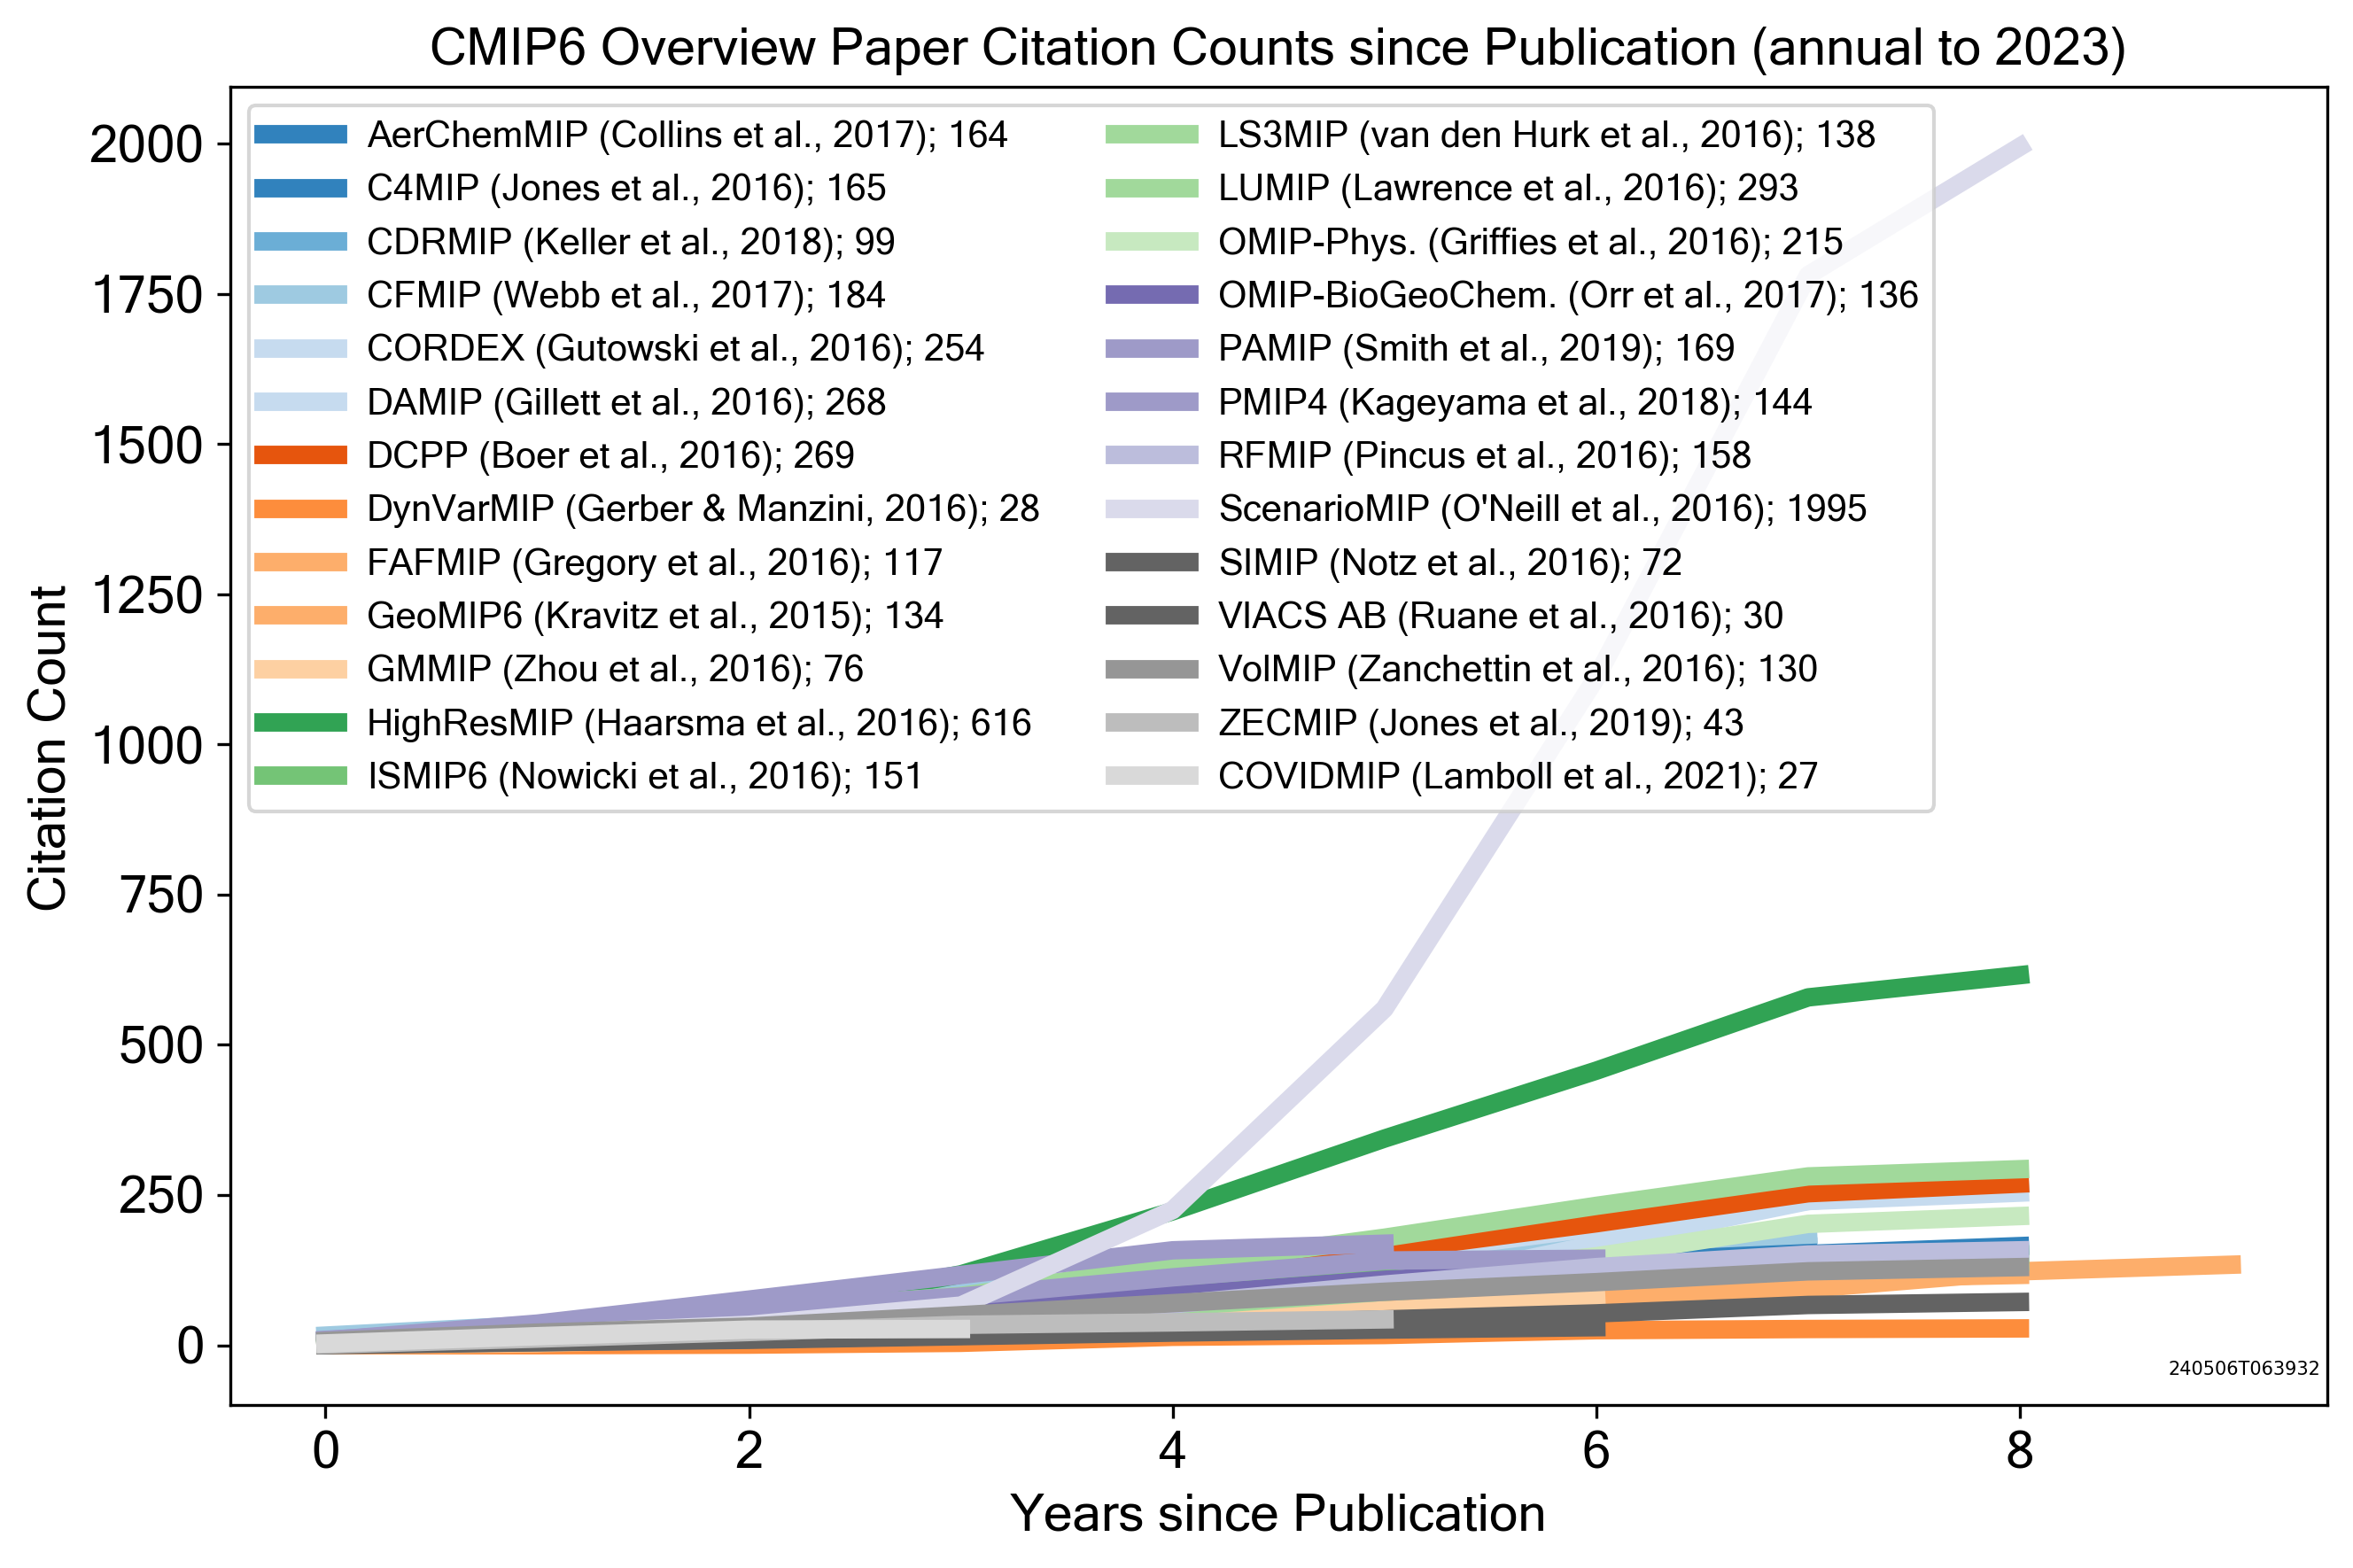

In [14]:
# Generate CMIP6 and per MIP

# Year since publication
yrSincePublication2 = np.arange(0, len(aerchemmip))

# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"
NUM_COLORS = 26
colList = []
cm = plt.get_cmap('tab20c')  # also tab 20b, tab20
for i in range(NUM_COLORS):
    colList.append(cm(1.*i/NUM_COLORS))
# string format
f = "{:0.0f}"
    
# create labels
actLabels = []
#actLabels.append('; '.join(["CMIP6 (Eyring et al., 2016)", f.format(np.nansum(cmip6))]))
#actLabels.append('; '.join(["CMIP6 (Composite 2015-)", f.format(np.nansum(cmip6Comp))]))
actLabels.append('; '.join(["AerChemMIP (Collins et al., 2017)", f.format(np.nansum(aerchemmip))]))
actLabels.append('; '.join(["C4MIP (Jones et al., 2016)", f.format(np.nansum(c4mip))]))
actLabels.append('; '.join(["CDRMIP (Keller et al., 2018)", f.format(np.nansum(cdrmip))]))
actLabels.append('; '.join(["CFMIP (Webb et al., 2017)", f.format(np.nansum(cfmip))]))
actLabels.append('; '.join(["CORDEX (Gutowski et al., 2016)", f.format(np.nansum(cordex))]))
actLabels.append('; '.join(["DAMIP (Gillett et al., 2016)", f.format(np.nansum(damip))]))
actLabels.append('; '.join(["DCPP (Boer et al., 2016)", f.format(np.nansum(dcpp))]))
actLabels.append('; '.join(["DynVarMIP (Gerber & Manzini, 2016)", f.format(np.nansum(dynvarmip))]))
actLabels.append('; '.join(["FAFMIP (Gregory et al., 2016)", f.format(np.nansum(fafmip))]))
actLabels.append('; '.join(["GeoMIP6 (Kravitz et al., 2015)", f.format(np.nansum(geomip6))]))
actLabels.append('; '.join(["GMMIP (Zhou et al., 2016)", f.format(np.nansum(gmmip))]))
actLabels.append('; '.join(["HighResMIP (Haarsma et al., 2016)", f.format(np.nansum(highresmip))]))
actLabels.append('; '.join(["ISMIP6 (Nowicki et al., 2016)", f.format(np.nansum(ismip6))]))
actLabels.append('; '.join(["LS3MIP (van den Hurk et al., 2016)", f.format(np.nansum(ls3mip))]))
actLabels.append('; '.join(["LUMIP (Lawrence et al., 2016)", f.format(np.nansum(lumip))]))
actLabels.append('; '.join(["OMIP-Phys. (Griffies et al., 2016)", f.format(np.nansum(omip1))]))
actLabels.append('; '.join(["OMIP-BioGeoChem. (Orr et al., 2017)", f.format(np.nansum(omip2))]))
actLabels.append('; '.join(["PAMIP (Smith et al., 2019)", f.format(np.nansum(pamip))]))
actLabels.append('; '.join(["PMIP4 (Kageyama et al., 2018)", f.format(np.nansum(pmip4))]))
actLabels.append('; '.join(["RFMIP (Pincus et al., 2016)", f.format(np.nansum(rfmip))]))
actLabels.append('; '.join(["ScenarioMIP (O'Neill et al., 2016)", f.format(np.nansum(scenariomip))]))
actLabels.append('; '.join(["SIMIP (Notz et al., 2016)", f.format(np.nansum(simip))]))
actLabels.append('; '.join(["VIACS AB (Ruane et al., 2016)", f.format(np.nansum(viacsab))]))
actLabels.append('; '.join(["VolMIP (Zanchettin et al., 2016)", f.format(np.nansum(volmip))]))
actLabels.append('; '.join(["ZECMIP (Jones et al., 2019)", f.format(np.nansum(zecmip))]))
actLabels.append('; '.join(["COVIDMIP (Lamboll et al., 2021)", f.format(np.nansum(covidmip))]))
print("actLabels:", len(actLabels), actLabels)
                 
# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

#cmip6, cmip6Comp, 
mips = [aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
        highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
        simip, viacsab, volmip, zecmip, covidmip]

# plot from year 1
for count, mip in enumerate(mips):
    print("mip:", mip)
    plt.plot(yrSincePublication2, np.cumsum(mip), linewidth=lineWidth, label=actLabels[count], color=colList[count])

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title("".join(["CMIP6 Overview Paper Citation Counts since Publication (annual to ", str(currentYr-1), ")"]),
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": 10}, loc="upper left", ncol=2)
plt.text(8.7, -50, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save, close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2a.png"]))

## second plot (b) - Contributing MIPs - bar plot

valsum: [164.0, 165.0, 99.0, 184.0, 254.0, 268.0, 269.0, 28.0, 117.0, 134.0, 76.0, 616.0, 151.0, 138.0, 293.0, 215.0, 136.0, 169.0, 144.0, 158.0, 1995.0, 72.0, 30.0, 130.0, 43.0, 27.0]
np.nansum(valsum): 6075.0
valsum %: [' 2.70%', ' 2.72%', ' 1.63%', ' 3.03%', ' 4.18%', ' 4.41%', ' 4.43%', ' 0.46%', ' 1.93%', ' 2.21%', ' 1.25%', '10.14%', ' 2.49%', ' 2.27%', ' 4.82%', ' 3.54%', ' 2.24%', ' 2.78%', ' 2.37%', ' 2.60%', '32.84%', ' 1.19%', ' 0.49%', ' 2.14%', ' 0.71%', ' 0.44%']
np.nansum(valsum %): 100.0
len(valsum): 26 ; len(labs): 26


/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_11526/478191817.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.axes.axes.set_yticklabels(ax1.get_yticklabels(), fontsize=fontSize, fontname=fontname)
/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_11526/478191817.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.axes.axes.set_yticklabels(ax2.get_yticklabels(), fontsize=fontSize, fontname=fontname)


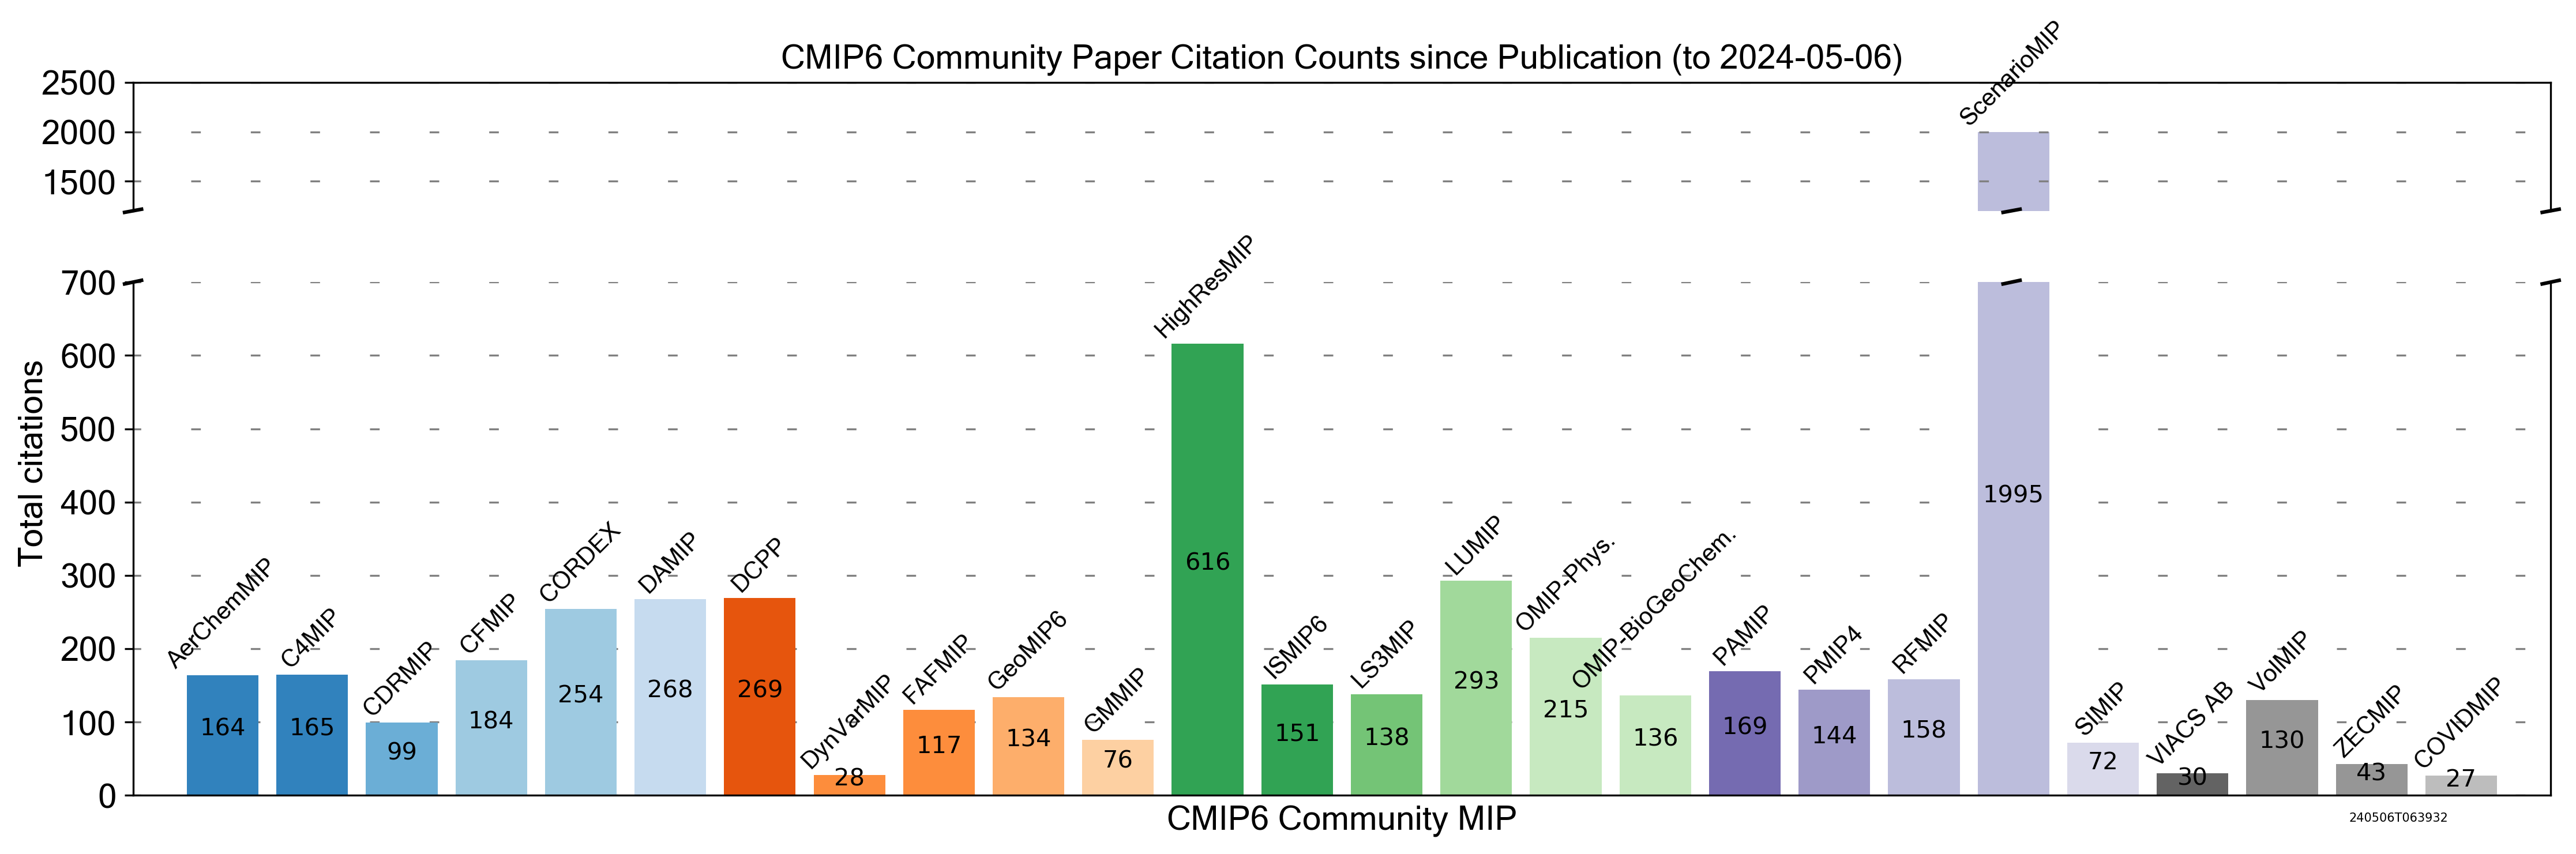

In [15]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=300, ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 4]})

# sort axis boxes
ax1.spines[['bottom']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax1.set_ylim(1200, 2500)
ax2.set_ylim(0, 700)
ax1.set_xlim(-1, 26)
ax2.set_xlim(-1, 26)
fig.tight_layout()

# fixed values
linesty = (1, (5, 26))
rot = 45
fontname = "Microsoft Sans Serif"
fontSize = 14
fontSizeLab = 10

# create colour bins
NUM_COLORS = 27
colList = []
cm = plt.get_cmap('tab20c')  # also tab 20b, tab20
for i in range(NUM_COLORS):
    colList.append(cm(1.*i/NUM_COLORS))

val = [aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
       simip, viacsab, volmip, zecmip, covidmip]
labs = ["AerChemMIP", "C4MIP", "CDRMIP", "CFMIP", "CORDEX", "DAMIP", "DCPP",
        "DynVarMIP", "FAFMIP", "GeoMIP6", "GMMIP", "HighResMIP", "ISMIP6", "LS3MIP",
        "LUMIP", "OMIP-Phys.", "OMIP-BioGeoChem.", "PAMIP", "PMIP4", "RFMIP",
        "ScenarioMIP", "SIMIP", "VIACS AB", "VolMIP", "ZECMIP", "COVIDMIP"]
valsum = []
for c,v in enumerate(val):
    tmp = np.nansum(v)
    valsum.append(tmp)

print("valsum:", valsum)
f = "{:5.2f}%"
print("np.nansum(valsum):", np.nansum(valsum))
perc = valsum/np.nansum(valsum) * 100
#print("valsum/np.nansum(valsum):", perc)
print("valsum %:", list(map(f.format,perc)))
print("np.nansum(valsum %):", np.nansum(perc))
print("len(valsum):", len(valsum), "; len(labs):", len(labs))

# Start plotting
b1 = ax1.bar(labs, valsum, color=colList)
b2 = ax2.bar(labs, valsum, color=colList)
ax1.grid(zorder=0)
ax1.grid(color='gray', linestyle=linesty)
ax1.bar_label(b1, labs, label_type='edge', color='k', rotation=rot, fontsize=fontSizeLab, padding=1, zorder=10, fontname=fontname)
ax1.axes.axes.set_yticklabels(ax1.get_yticklabels(), fontsize=fontSize, fontname=fontname)
ax2.grid(zorder=0)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle=linesty)
ax2.bar_label(b2, labs, label_type='edge', color='k', rotation=rot, fontsize=fontSizeLab, padding=1, zorder=10, fontname=fontname)
ax2.set_ylabel("Total citations", fontsize=fontSize, fontname=fontname)
ax2.yaxis.set_label_coords(-.035, .65)
ax2.axes.axes.set_yticklabels(ax2.get_yticklabels(), fontsize=fontSize, fontname=fontname)
ax2.set_xlabel("CMIP6 Community MIP", fontsize=fontSize, fontname=fontname)
ax2.set_xticks([])
ax1.set_title("".join(["CMIP6 Community Paper Citation Counts since Publication (to ", datetime.date.today().strftime("%Y-%m-%d"), ")"]),
             fontsize=fontSize, fontname=fontname)
plt.text(23.75, -35, ' '.join([timeFormat]), fontsize=5)

# function to add value labels
f = "{:0.0f}"
def addlabels(x,y):
    for i in range(len(x)):
        y1 = f.format(y[i])
        if i == 20:
            plt.text(i, 400, y1, ha = "center")
        else:
            plt.text(i, y[i]//2, y1, ha = "center")

addlabels(labs, valsum)

# arguments to pass to plot, just so we don't keep repeating them
# following https://gist.github.com/pfandzelter/0ae861f0dee1fb4fd1d11344e3f85c9e
d = .0035  # how big to make the diagonal lines in axes coordinates
scale = 350/100  # upper scale more compressed
scenX = 0.777 #.807  # ScenarioMIP x-intercept
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-d*scale, +d*scale), **kwargs)  # top-left diagonal
ax1.plot((scenX - d, scenX + d), (-d*scale, +d*scale), **kwargs)  # ScenarioMIP diagonal
ax1.plot((1 - d, 1 + d), (-d*scale, +d*scale), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((scenX - d, scenX + d), (1 -d, 1 +d), **kwargs)  # ScenarioMIP diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# fill canvas
fig.tight_layout()

# display, save, close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2b-bar.png"]))

## third plot - MIPs and composite CMIP6

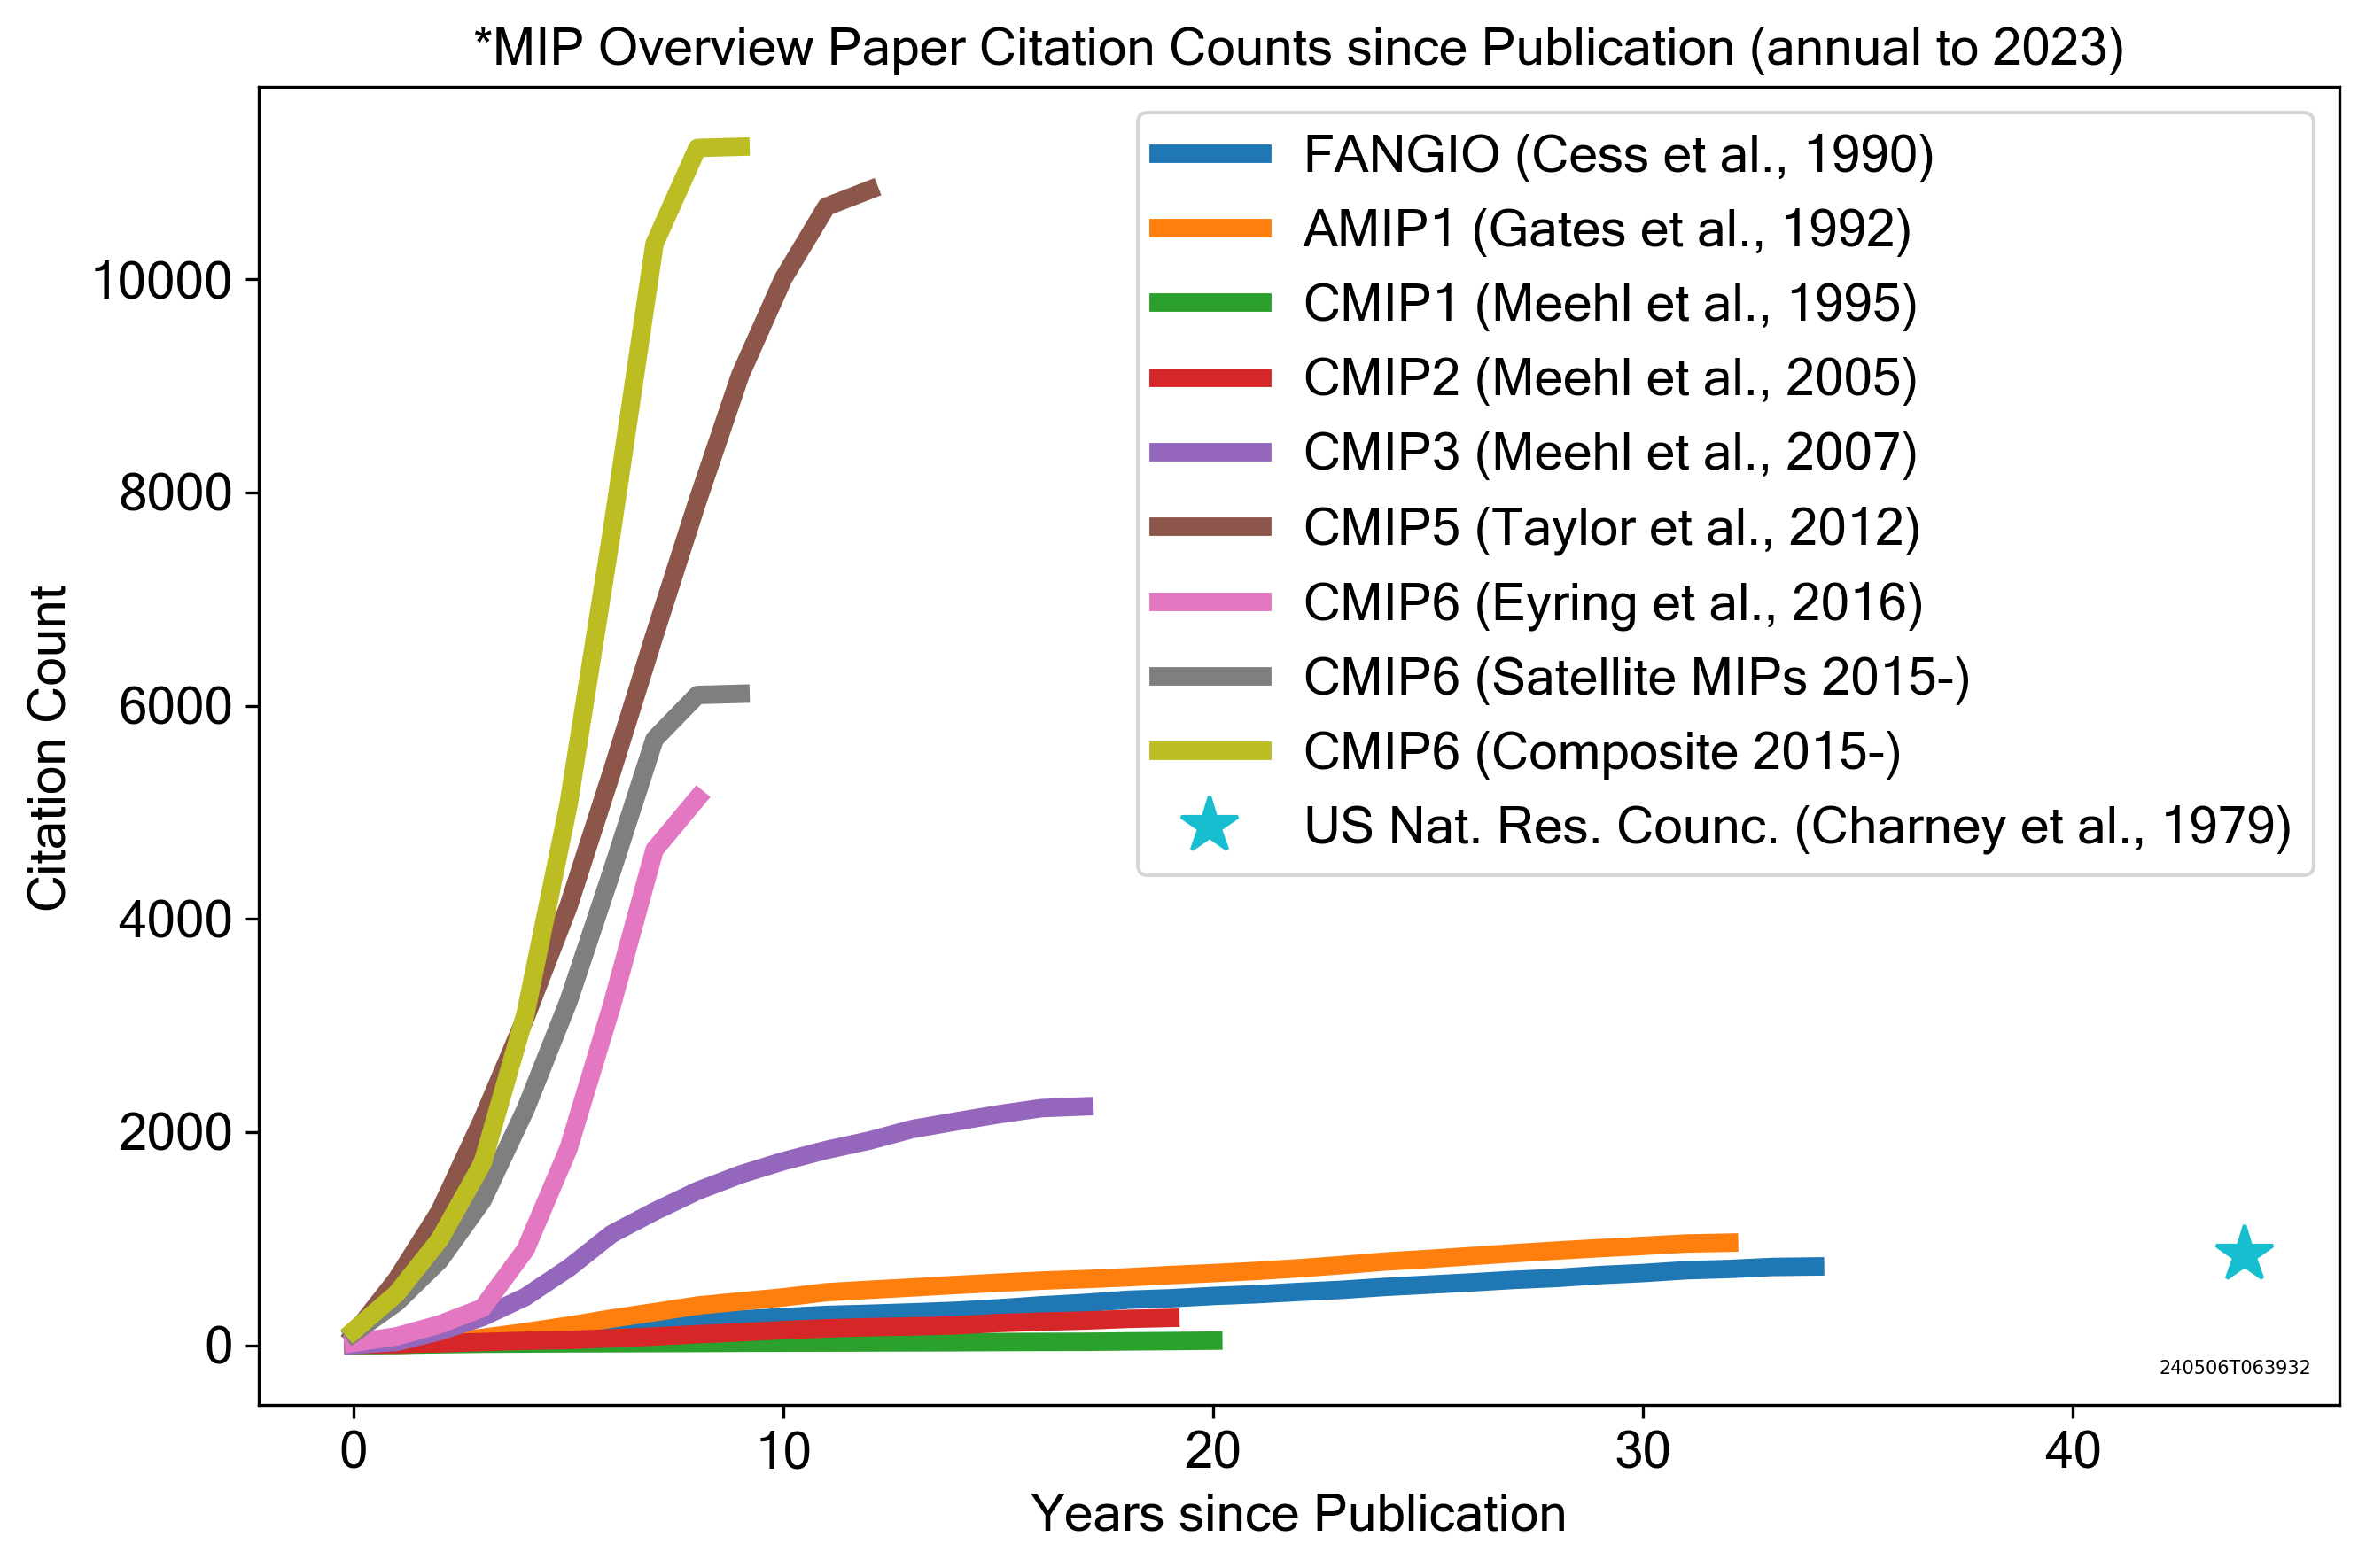

In [16]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
line7 = plt.plot(yrSincePublication, np.cumsum(cmip6Comp), linewidth=lineWidth, label="CMIP6 (Satellite MIPs 2015-)")
line8 = plt.plot(yrSincePublication, np.cumsum(cmip6CompA), linewidth=lineWidth, label="CMIP6 (Composite 2015-)")
star0 = plt.plot(2023-1979, charneyG, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title, custom x-axis tick labels, etc.
ax.set_title("".join(["*MIP Overview Paper Citation Counts since Publication (annual to ", str(currentYr-1), ")"]),
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})
plt.text(42, -270, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save, close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-3.png"]))

## fourth plot - MIPs + CCSM4, CESM1, CESM2, E3SM-1-0

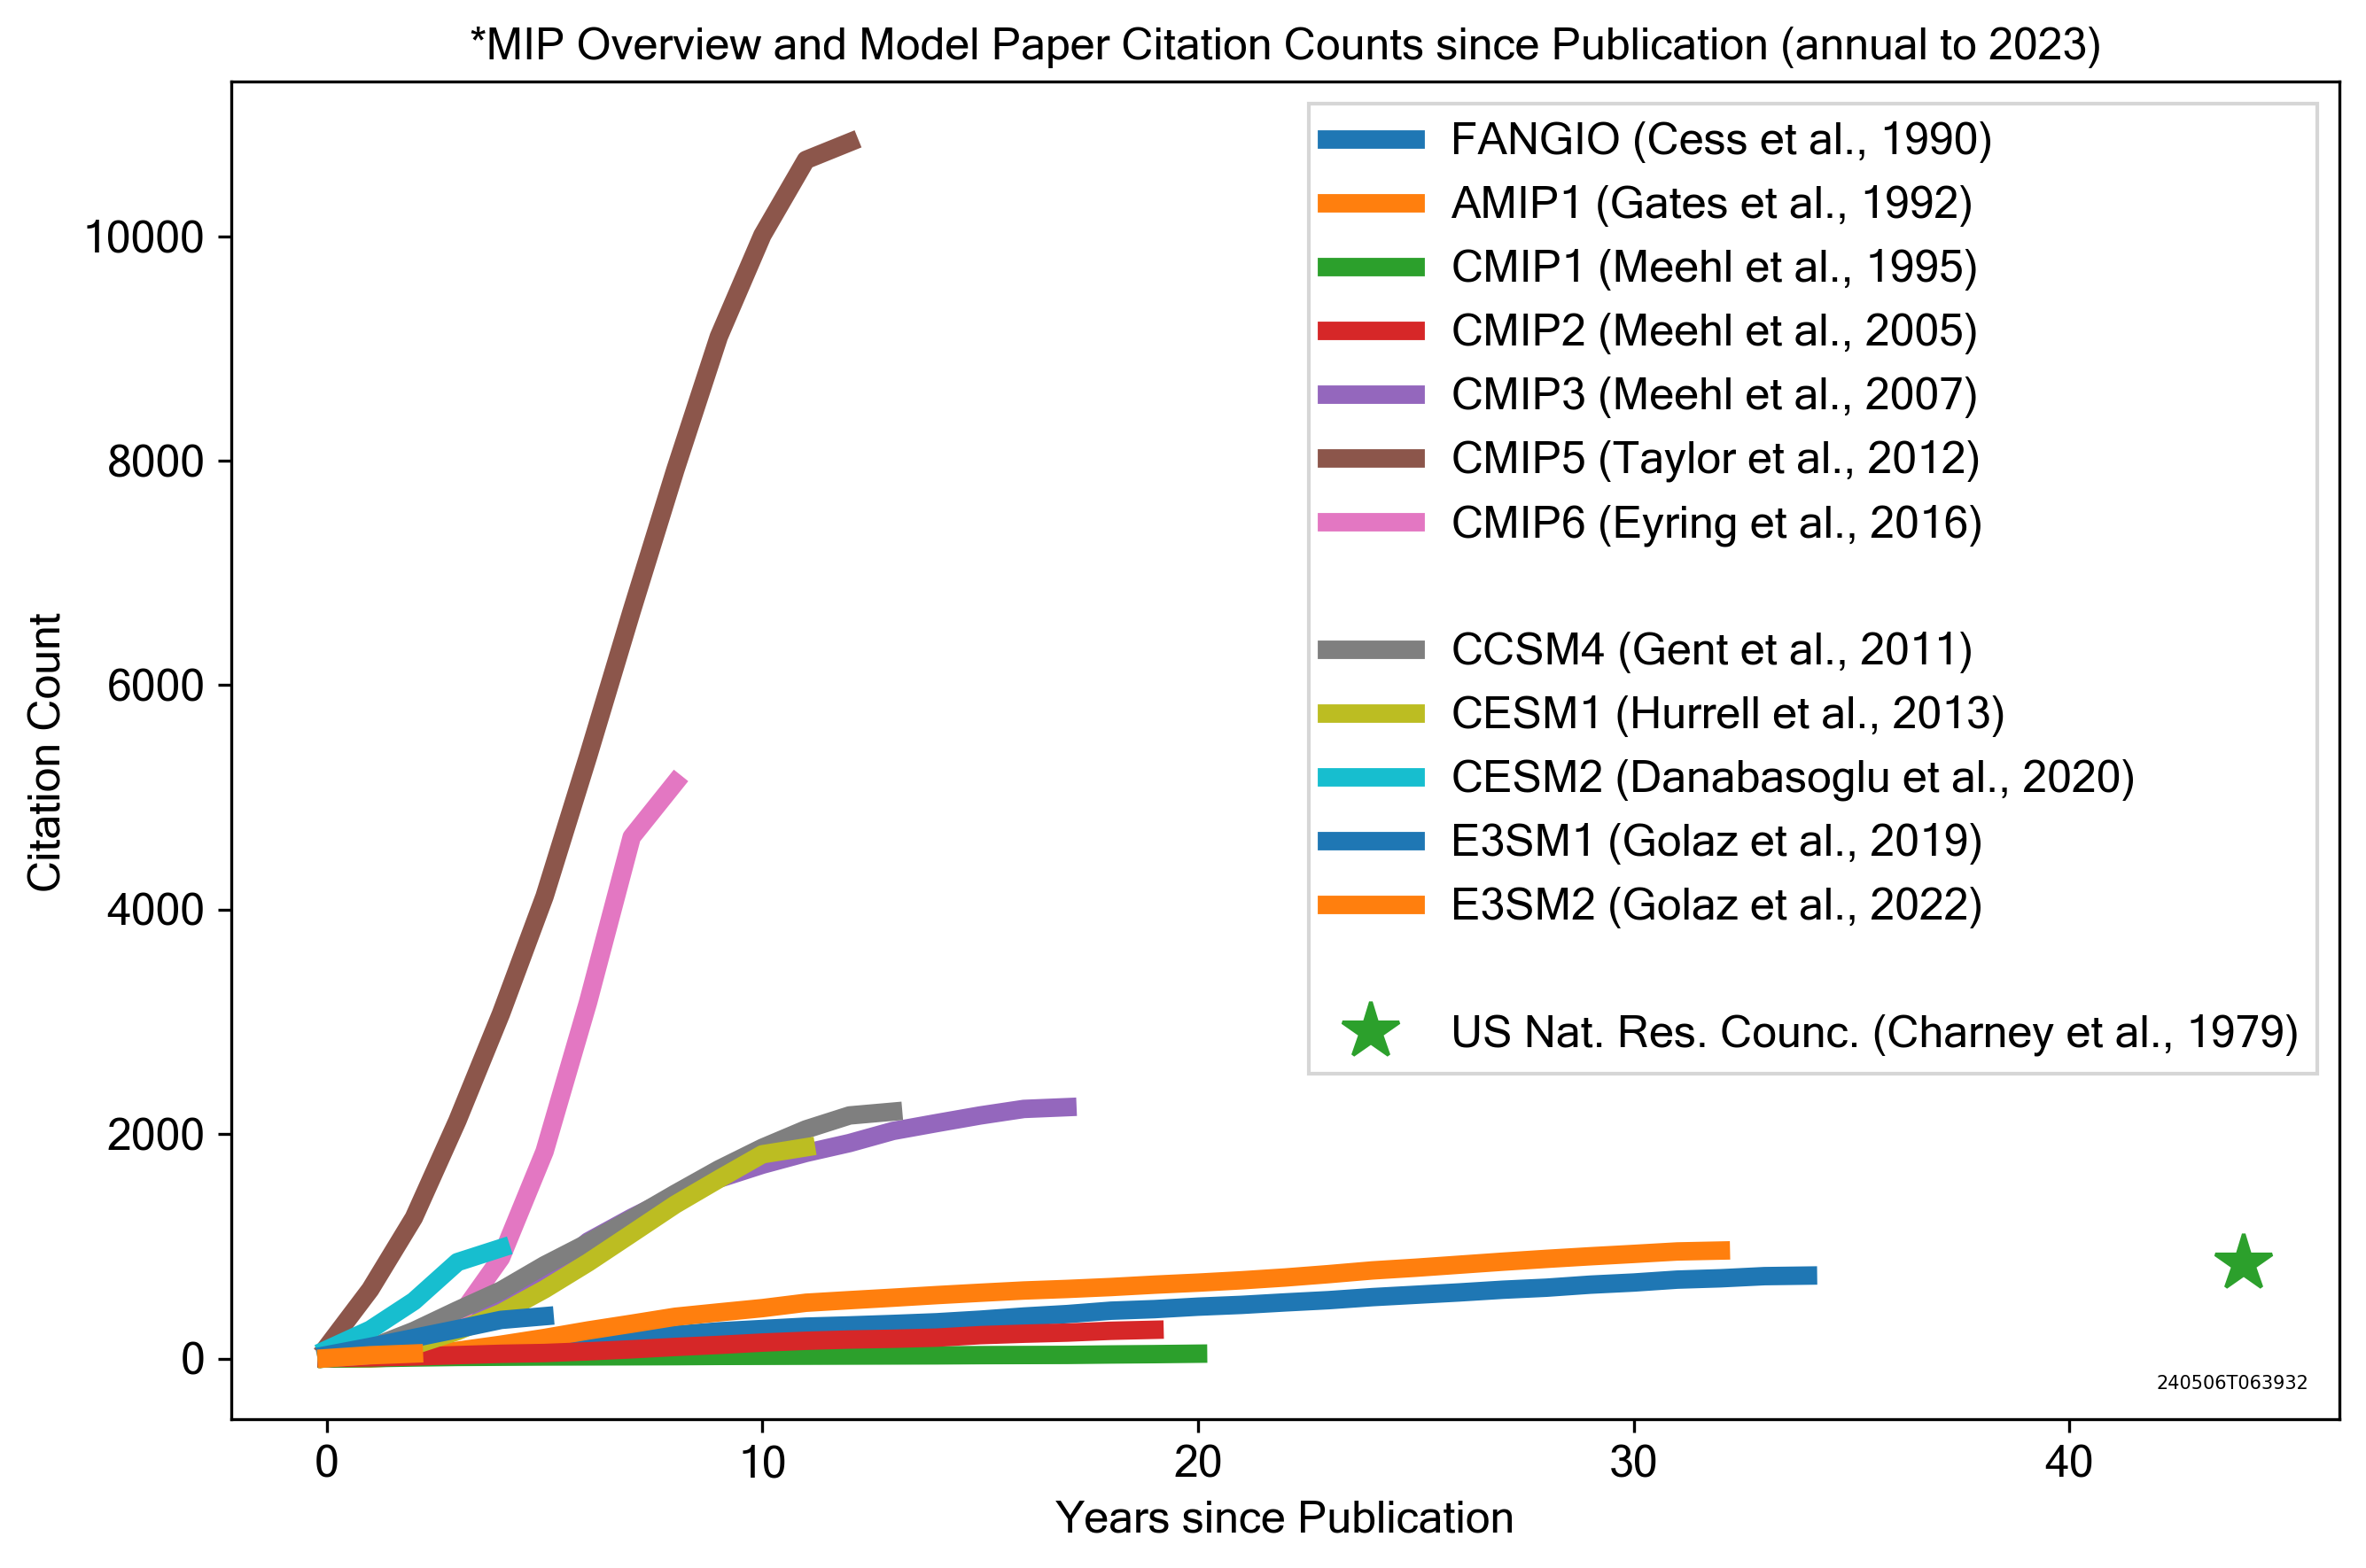

In [17]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 12
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0, = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth)
line1, = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth)
line2, = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth)
line3, = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth)
line4, = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth)
line5, = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth)
line6, = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth)
line7, = plt.plot(yrSincePublication, citingYrsPad, color="w")
line8, = plt.plot(yrSincePublication, np.cumsum(ccsm4), linewidth=lineWidth)
line9, = plt.plot(yrSincePublication, np.cumsum(cesm1), linewidth=lineWidth)
line10, = plt.plot(yrSincePublication, np.cumsum(cesm2), linewidth=lineWidth)
line11, = plt.plot(yrSincePublication, np.cumsum(e3sm1_0), linewidth=lineWidth)
line12, = plt.plot(yrSincePublication, np.cumsum(e3sm2_0), linewidth=lineWidth)
line13, = plt.plot(yrSincePublication, citingYrsPad, color="w")
star0, = plt.plot(2023-1979, charneyG, marker="*", markersize=16, linestyle="None")

# pretty things up - add text for labels, title, custom x-axis tick labels, etc.
ax.set_title("".join(["*MIP Overview and Model Paper Citation Counts since Publication (annual to ", str(currentYr-1), ")"]),
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8, line9, line10, line11, line12, line13, star0),
          ("FANGIO (Cess et al., 1990)", "AMIP1 (Gates et al., 1992)", "CMIP1 (Meehl et al., 1995)",
           "CMIP2 (Meehl et al., 2005)", "CMIP3 (Meehl et al., 2007)", "CMIP5 (Taylor et al., 2012)",
           "CMIP6 (Eyring et al., 2016)", "", "CCSM4 (Gent et al., 2011)",
           "CESM1 (Hurrell et al., 2013)", "CESM2 (Danabasoglu et al., 2020)",
           "E3SM1 (Golaz et al., 2019)", "E3SM2 (Golaz et al., 2022)", 
           "", "US Nat. Res. Counc. (Charney et al., 1979)"),
          loc='upper right', fancybox=False, ncol=1,
          prop={"family": fontName, "size": fontsize})
plt.text(42, -270, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save, close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-4.png"]))